In [2]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200
import matplotlib.colors as colors
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import numpy.linalg as la
from sklearn.metrics import r2_score
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import StepLR
from pathlib import Path

### **BCI Data Processing**

In [ ]:
mpl.rcParams['figure.dpi'] = 300 #set resolution of matplots to 300DPI

date = '070323'
mouse = '58'

cd "C:\Users\andre\Desktop\active_neuron"

# keys of the np array dictionary
data_all = np.load('data/BCI_' + mouse + '-' + date + '.npy', allow_pickle = True).item()
data_all.keys()

data = []
dataset_id = 0
data.append(data_all['photostim'])

# keys of each photostim
data[dataset_id].keys()

In [ ]:
data[dataset_id]['Fstim'].shape
data[dataset_id]['FstimRaw'].shape
seq = data[dataset_id]['seq']
seq
data[dataset_id].keys()
stimDist = data[dataset_id]['stimDist']
data[dataset_id]['stimPosition'].shape
data_all['photostim']['slmDist'].shape
data_all['photostim']['stimDist'].shape

In [ ]:
stim_group_id = 0
#neurons with distance to stimulation laser of less than 50
close_perturbation_center_neuron_ids = data_all['photostim']['slmDist'][:,stim_group_id] < 50
#indices of neurons with a distance to stimulation target of less than 30
target_neuron_ids = np.where(data_all['photostim']['stimDist'][:,stim_group_id] < 30)[0]

#all neurons
plt.scatter(data_all['photostim']['centroidX'], data_all['photostim']['centroidY'], s = 2)

#orange is the stimulation points
plt.scatter(data[dataset_id]['stimPosition'][:,0,stim_group_id], data[dataset_id]['stimPosition'][:,1,stim_group_id], s = 6, alpha = 1.0, color = 'orange')

#target neurons with distance of <30 from earlier
plt.scatter(np.asarray(data_all['photostim']['centroidX'])[target_neuron_ids], np.asarray(data_all['photostim']['centroidY'])[target_neuron_ids], color = 'green', s = 2)
plt.scatter(np.asarray(data_all['photostim']['centroidX'])[target_neuron_ids], np.asarray(data_all['photostim']['centroidY'])[target_neuron_ids], color = 'green', s = 2)
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')

In [ ]:
#first 100 stimulation points data
data[dataset_id]['stimID'][:100]


stimID = (data[dataset_id]['stimID'])
np.where(stimID != 0)

In [ ]:
### padding zero right end to correct the shift
#stimID - ID that denote specific stimulation events
#FstimRaw - raw data that represents response of neurons during experiment
stimID_correct = (data[dataset_id]['stimID']).copy()
stimID_correct[:-1] = data[dataset_id]['stimID'][1:]

#compare plots of mean of first 50 elements of 'FstimRaw' this is blue
plt.plot(np.mean(data[dataset_id]['FstimRaw'],axis=0)[:50])

#orange plot of stimulation data
plt.plot(stimID_correct[:50]*2)                                               

In [ ]:
num_trials = np.where(stimID_correct != 0)[0].shape[0]
num_neurons = data[dataset_id]['FstimRaw'].shape[0]
interp_len = 3
Fstim_interp = data[dataset_id]['FstimRaw'].copy()
Fstim_baseline_mean = np.mean(Fstim_interp, axis = 1)
Fstim_baseline_std = np.std(Fstim_interp, axis = 1)
Fstim_interp_norm = Fstim_interp
stim_steps = np.where(stimID_correct != 0)[0]

In [ ]:
stim_dist = 10
num_unique_groups = 100
stim_input = np.zeros(Fstim_interp.shape[1])
stim_input_id = np.zeros((Fstim_interp.shape[1], num_neurons))
stim_input_group_id = np.zeros((Fstim_interp.shape[1], num_unique_groups))
stim_continuous_input_id = np.zeros((Fstim_interp.shape[1], num_neurons))
data_all['photostim']['slmDist']
for i in range(stim_steps.shape[0]):
    stim_input[stim_steps[i]: stim_steps[i] + interp_len] = 1
    stim_group_id = int(stimID_correct[stim_steps[i]] - 1)
    stim_neuron_ids = np.where(stimDist[:,stim_group_id]<stim_dist)[0]
    target_mask = np.zeros((num_neurons))
    target_mask[stim_neuron_ids]  = 1
    stim_input_id[stim_steps[i]: stim_steps[i] + interp_len, :] = target_mask
    spatial_input = np.exp(-data_all['photostim']['stimDist'][:,stim_group_id]/10) * np.exp(-data_all['photostim']['slmDist'][:,stim_group_id]/200)
    stim_continuous_input_id[stim_steps[i]: stim_steps[i] + interp_len, :] = spatial_input
    stim_input_group_id[stim_steps[i]: stim_steps[i] + interp_len, stim_group_id] = 1 

In [ ]:
data_save = {
        'u_session': stim_input_id,
        'u_spatial_session': stim_continuous_input_id,
        'y_session': Fstim_interp_norm.T,
        'x1': np.asarray(data_all['photostim']['centroidX']),
        'x2': np.asarray(data_all['photostim']['centroidY']),
        'o1': data[dataset_id]['stimPosition'][:,0,:],
        'o2': data[dataset_id]['stimPosition'][:,1,:]}
np.save('sample_photostim_'+ mouse + '_spatial_date_' + date + '.npy', data_save)

In [ ]:
pre_trans_path = r"C:\Users\andre\Desktop\active_neuron\data\BCI_58-071223.npy"
#trans_path = r"C:\Users\andre\Desktop\active_neuron\sample_photostim_58_spatial_date_071223.npy"

pre_trans_data = np.load(pre_trans_path, allow_pickle=True)
#trans_data = np.load(trans_path, allow_pickle=True)

print(pre_trans_data)
#print(trans_data)

In [ ]:
# session data
y_session = data_save['y_session']
u_session = data_save['u_session']
print('y_session', y_session.shape)
print('u_session', u_session.shape)

In [ ]:
# nan represent removed interpolated steps in y
fig, axes = plt.subplots(2, 1, figsize=(20,10))
time_wind_start = 840
time_wind_end = 1240
neuron_start = 0
neuron_end = 1000

axes[0].imshow(u_session[time_wind_start: time_wind_end, neuron_start:neuron_end].T)
# axes[0].set_title('stimulation inputs')
# axes[0].set_xlabel('time steps')
# axes[0].set_ylabel('neuron id')
im = axes[1].imshow(y_session[time_wind_start: time_wind_end, neuron_start:neuron_end].T)
fig.colorbar(im)
# axes[1].set_title('in vivo calcium recording')
# axes[1].set_xlabel('time step')
# axes[1].set_ylabel('neuron id')
fig.savefig('photo_intro.pdf')

In [ ]:
# nan represent removed interpolated steps in y
fig, axes = plt.subplots(2, 1, figsize=(20,10))
time_wind_start = 1140
time_wind_end = 1940
neuron_start = 0
neuron_end = 1000

axes[0].imshow(u_session[time_wind_start: time_wind_end, neuron_start:neuron_end].T)
# axes[0].set_title('stimulation inputs')
# axes[0].set_xlabel('time steps')
# axes[0].set_ylabel('neuron id')
im = axes[1].imshow(y_session[time_wind_start: time_wind_end, neuron_start:neuron_end].T - y_session[0, neuron_start:neuron_end][None,:].T, cmap='bwr', vmin = -400, vmax = 400)
fig.colorbar(im)
# axes[1].set_title('in vivo calcium recording')
# axes[1].set_xlabel('time step')
# axes[1].set_ylabel('neuron id')
fig.savefig('photo_intro.pdf')

In [ ]:
# nan represent removed interpolated steps in y
fig, axes = plt.subplots(2, 1, figsize=(30,10))
time_wind_start = 1000
time_wind_end = 2000
axes[0].plot(u_session[time_wind_start: time_wind_end].T)
axes[0].set_title('stimulation inputs')
axes[0].set_xlabel('time steps')
axes[0].set_ylabel('neuron id')
axes[1].plot(y_session[time_wind_start: time_wind_end].T)
axes[1].set_title('in vivo calcium recording')
axes[1].set_xlabel('time step')
axes[1].set_ylabel('neuron id')
fig.savefig('photo_intro.pdf')

### **Low Rank Model Code**

In [3]:
path = r"C:\Users\andre\Desktop\active_neuron\sample_photostim_58_spatial_date_071223.npy"
d = np.load(path, allow_pickle=True).item()

for key in d.keys():
    print(key)


d

#29402 trials and 507 neurons
print(d['u_session'].shape)  #(29402, 507)
print(d['u_spatial_session'].shape)  #(29402, 507)
print(d['y_session'].shape)  #(29402, 507)

#x1 and x2 = 507 neurons
print(d['x1'].shape)  #(507,)
print(d['x2'].shape)  #(507,)

# print("x1 sample data:", d['o1'][:2])
# print("o1 sample data:", d['o1'][:2])

#??????? What is o1 and o2
print(d['o1'].shape)  #(10, 100)
print(d['o2'].shape)  #(10, 100)



u_session
u_spatial_session
y_session
x1
x2
o1
o2
(29402, 507)
(29402, 507)
(29402, 507)
(507,)
(507,)
(10, 100)
(10, 100)


In [4]:
#Fills in NaN values in y_session

data = np.load(path, allow_pickle = True).item() #dict

y_session = data['y_session']  #np.ndarray
u_session = data['u_session']  #np.ndarray

y_session_interp = y_session.copy()
for i in range(y_session.shape[1]):  #i loop over 507 neuron cols
    nan_start = -1
    nan_stop = -1
    for j in range(y_session.shape[0]):  #j loop over 29402 trial rows
        if nan_start == -1 and np.isnan(y_session_interp[j,i]):
            nan_start = j - 1  #set nan_start to index just before detected NaN element
        if nan_start != -1 and not np.isnan(y_session_interp[j,i]):
            nan_stop = j  #set nan_stop to index of detected non_nan element 
        if nan_start != -1 and nan_stop != -1: #if a valid nan interval has been detected
            slope = y_session_interp[nan_stop,i] - y_session_interp[nan_start,i]
            for k in range(nan_stop - nan_start - 1):  #linearly interpolate the detected nan interval
                y_session_interp[nan_start + k + 1,i] = slope*k/(nan_stop-nan_start-1) + y_session_interp[nan_start,i]
            nan_start = -1
            nan_stop = -1


added this pattern: [  3   4  52  64  77 229 235 247 257 273 466 472 505]
pattern count is now [1]
added pattern index [[0]]
pattern length is now [13]
 
added this pattern: [ 41  77  94 141 257 263 281 318 349 398 412]
pattern count is now [1, 1]
added pattern index [[0], [15]]
pattern length is now [13, 11]
 
added this pattern: [ 51  73 128 155 171 186 278 286 290 323 418 445]
pattern count is now [1, 1, 1]
added pattern index [[0], [15], [29]]
pattern length is now [13, 11, 12]
 
added this pattern: [  2   5  18  78  91 112 115 135 182 214 242 323 418]
pattern count is now [1, 1, 1, 1]
added pattern index [[0], [15], [29], [43]]
pattern length is now [13, 11, 12, 13]
 
added this pattern: [ 46  57  72 113 213 220 343 403]
pattern count is now [1, 1, 1, 1, 1]
added pattern index [[0], [15], [29], [43], [58]]
pattern length is now [13, 11, 12, 13, 8]
 
added this pattern: [ 12  41  94 139 174 223 224 254 469]
pattern count is now [1, 1, 1, 1, 1, 1]
added pattern index [[0], [15], [29

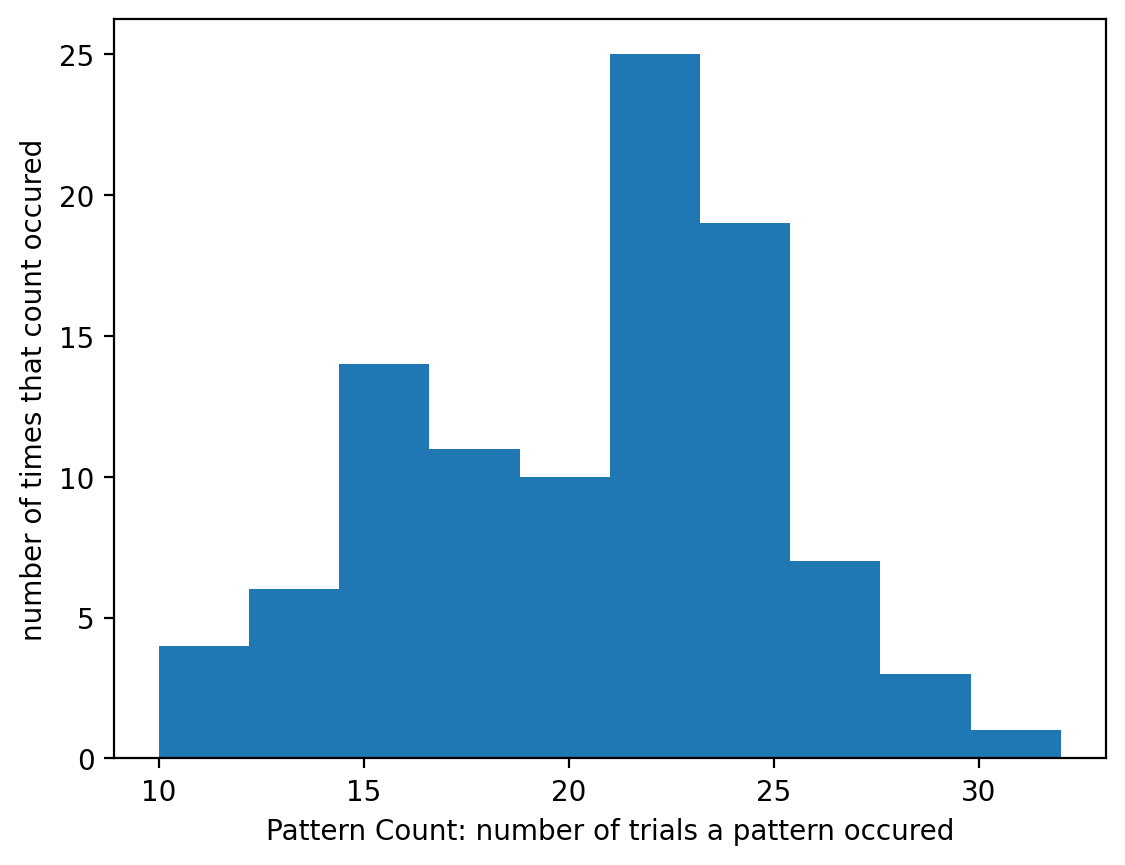

In [18]:
#Pattern counting, a pattern is the non-zero/stimulated neurons

patterns = []
pattern_count = []
pattern_idx = []
pattern_length = []

start = -10
for t in range(u_session.shape[0]):  #loop through t

    #if there is a single non_zero element in t-th row of u_session 
    #and if t is more than 4 units greater than start
    if np.sum(np.abs(u_session[t,:])) > 0 and t > start + 4:
        #generate np.ndarray of size of neuron count  
        idx = np.linspace(0,507-1,507).astype(int)

        #store boolean array mask of whether the data in the 
        #t-th row of u_session is greater than 0 or not
        on = u_session[t,:] > 0

        #pattern is new np.ndarray of just the nonzero elements 
        #of u_session[t,:]
        pattern = np.array(idx[on])

        start = t  #set start to the current trial we are on
        found = False
        for i in range(len(patterns)):
            if len(pattern) == len(patterns[i]):
                #if pattern and patterns[i] are the same
                if np.linalg.norm(pattern - patterns[i]) == 0:
                    pattern_count[i] += 1
                    print(f"pattern count is now added and is {pattern_count}")
                    pattern_idx[i].append(t)
                    found = True
                    break
        if found is False:
            patterns.append(pattern)  #there are 100 patterns
            pattern_count.append(1)
            pattern_idx.append([t])  #append the trial as the pattern_idx
            pattern_length.append(len(pattern))

            print(f"added this pattern: {pattern}")
            print(f"pattern count is now {pattern_count}")
            print(f"added pattern index {pattern_idx}")
            print(f"pattern length is now {pattern_length}")
            print(" ")

#counting how many patterns each neuron is involved in, store in neuron_pattern
neuron_pattern = np.zeros(507)
for i in range(507):
    for p in patterns:
        if i in p:
            neuron_pattern[i] += 1


plt.hist(pattern_count)
plt.xlabel('Pattern Count: number of trials a pattern occured')
plt.ylabel('number of times that count occured')
plt.show()

#(20, 10) means there are 10 unique patterns 
#that occurred exactly 20 times across all trials

In [33]:
# print(patterns)
print(patterns[99])
# print(len(patterns))
# print(pattern_count)
# print(len(pattern_count))
print(pattern_idx[99])
# print(len(pattern_idx))
# print(u_session.shape[0])
# print(pattern)

[ 12  31  47  77  85  92 139 158 174 257 309 319]
[11953, 13539, 16384, 17098, 17311, 18026, 21257, 22975, 24034, 25072, 25944, 26284]


pattern id: 44
pattern id: 47
pattern id: 64
pattern id: 67
pattern id: 67
pattern id: 9
print the number of removed t's 6571.0
105 0.22348819808176315
[44, 47, 64, 67, 9]
5


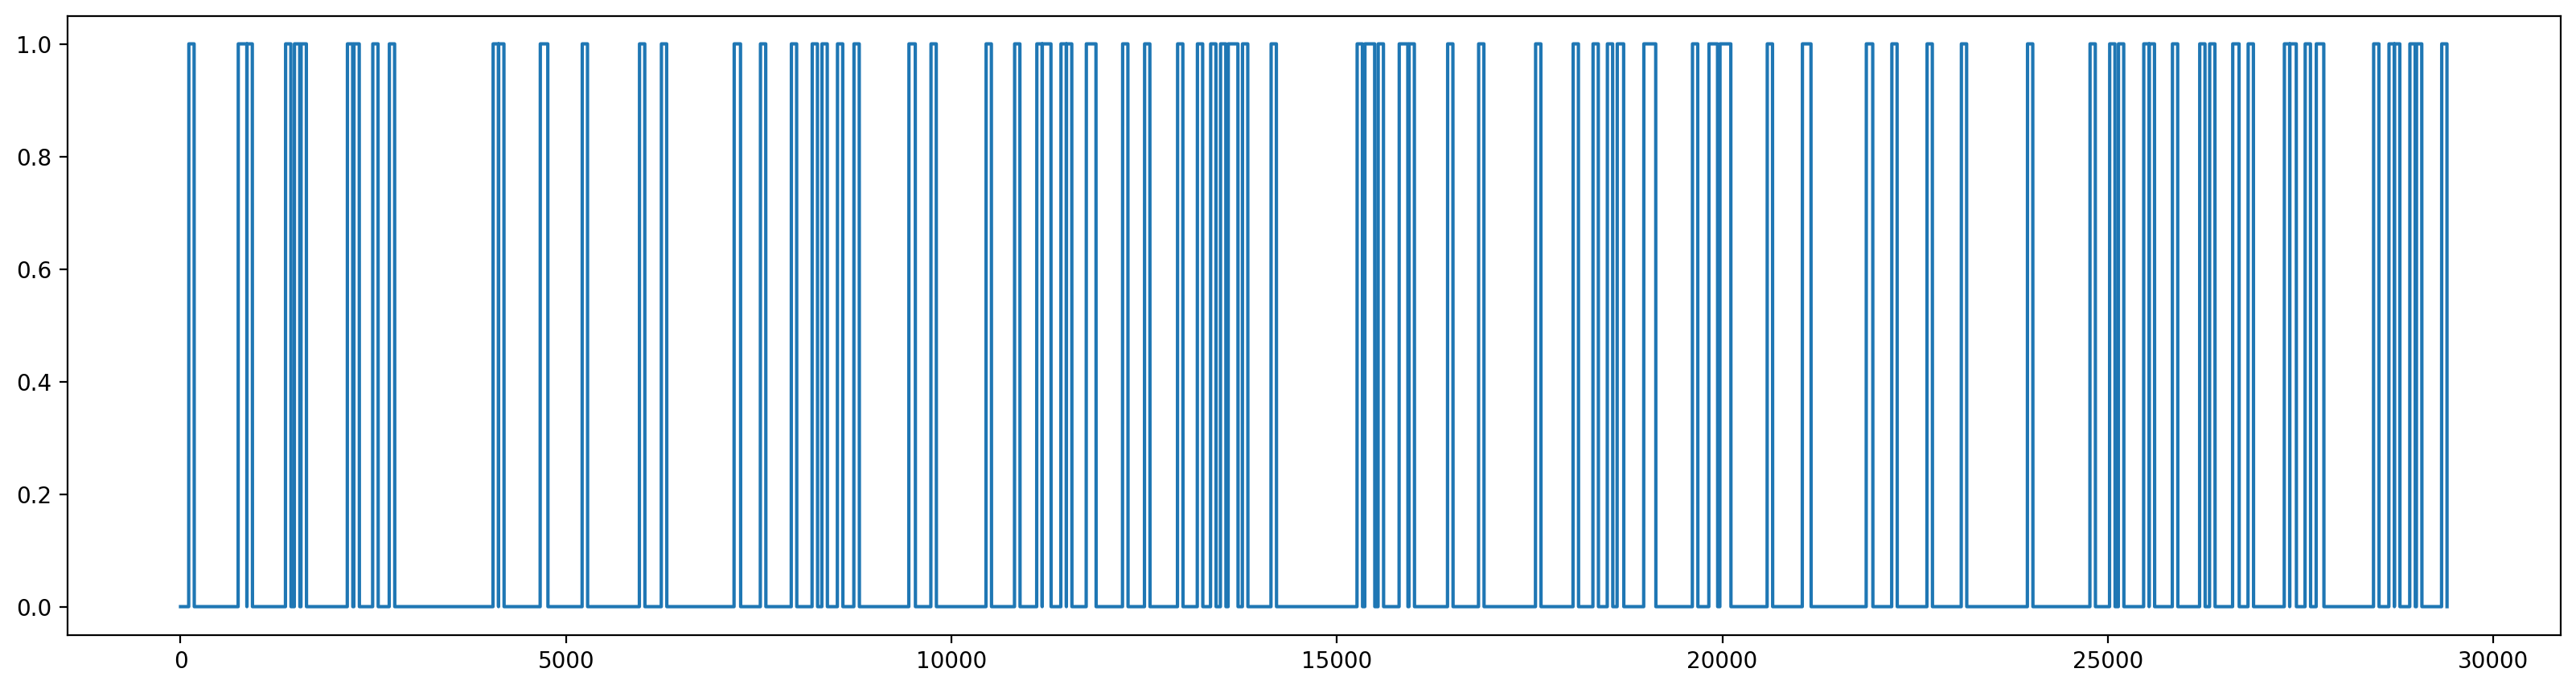

In [29]:
# remove patterns randomly
# ??????? if there are 100 patterns, not sure why we are randomly only removing 5, talk through pattern removing in general
num_patterns = 5
removed_patterns = []
removed_neurons = []
removed_steps = np.zeros(u_session.shape[0])
removed_count = 0

np.random.seed(0)
while len(removed_patterns) < num_patterns:
    p_idx = np.random.randint(0,len(patterns))  #pick random pattern index, 1-100
    print('pattern id:', p_idx)
    if p_idx not in removed_patterns:
        removed_patterns.append(p_idx)
        removed_count += pattern_count[p_idx]  # += will be a number like 22
        # print(f"removed patterns is now {removed_patterns}")
        # print(f"removed count is now {removed_count}")
        
        #add each [1,99,500, etc.] pattern of neurons at p_idx to removed_neurons
        removed_neurons.extend(patterns[p_idx])  
        #p_idx represents the index of a pattern composed of t's or trials

        #looping through the t's in the pattern at p_idx
        #for each 2226, 6300,... 20000 etc. there are 100 of these 
        #remove interval from 20 before t to 50 after t
        for i in pattern_idx[p_idx]:  
            min_idx = np.max([0,i-20])
            max_idx = np.min([i+50,u_session.shape[0]-1])
            #marked all t's in this interval for removal with a 1
            removed_steps[min_idx:max_idx] = 1

print(f"print the number of removed t's {np.sum(removed_steps)}")
print(removed_count, np.sum(removed_steps) / u_session.shape[0])
print(removed_patterns)  #the 5 removed pattern indexes
print(len(removed_patterns))
plt.figure(figsize=(20,5))
plt.plot(removed_steps)
plt.show()

test_indices = removed_steps.astype(int)
train_indices = np.ones(test_indices.shape[0]).astype(int) - test_indices.copy()
removed_neurons = list(set(removed_neurons))

train_test_split = {}
train_test_split['train_indices'] = train_indices
train_test_split['test_indices'] = test_indices
# np.save('train_test_split',train_test_split)

In [30]:
print(len(train_indices))
print(len(test_indices))

print(np.sum(train_indices))
print(np.sum(test_indices))

print(pattern_idx[p_idx])
print(removed_count)

29402
29402
22831
6571
[127, 1497, 2513, 4715, 5973, 7201, 8213, 8340, 10469, 11127, 12240, 13625, 13795, 15441, 15956, 18342, 20003, 20602, 22218, 25557, 25858, 27381, 27753, 28468, 29351]
105


In [83]:
print(removed_neurons)
print(len(removed_neurons))
print(removed_neurons[3])
print(removed_neurons[29])

print(removed_neurons[3])

print(patterns[44])
print(patterns[47])
print(patterns[64])
print(patterns[67])
print(patterns[9])

[384, 395, 11, 273, 19, 408, 280, 153, 32, 160, 293, 296, 43, 173, 303, 49, 178, 58, 315, 191, 320, 457, 76, 335, 338, 84, 88, 90, 95, 480, 227, 231, 232, 127, 367, 368, 496, 370, 243, 499, 242, 374, 250, 380, 381, 255]
46
273
480
273
[ 49  76  95 178 231 232 243 255 296 374 499]
[ 19  58  76  90 273 293 303 338 368 408 480]
[ 32  76  84  88 250 335 370 395]
[ 11 160 242 280 315 320 367 380 381 457 496]
[ 43 127 153 173 191 227 231 338 370 384 408]


In [77]:
#???????Do not understand the purpose of this block and the "check" its doing

removed_pattern_ids = [44, 47, 64, 67, 9]
check_neuron_id = removed_neurons[3]

count = 0
for pattern_id in range(len(patterns)):  #pattern_id is 0-100
    if pattern_id not in removed_pattern_ids:
        if check_neuron_id in patterns[pattern_id]:
            count += 1
print(count)

6


In [32]:
spiking = np.zeros(u_session.shape).astype(bool)

for neuron in range(u_session.shape[1]):
    output_true = y_session_interp[4:,neuron]

    #baseline activity level for neuron
    mean_threshold = np.median(output_true)

    #idxs of t's where activity is lower than baseline
    lower_tail_idx = (output_true < mean_threshold)
    lower_tail_data = output_true[lower_tail_idx]
    lower_tail_std = np.std(lower_tail_data)
    # print(lower_tail_std)

    true_spike_threshold = mean_threshold + 6*lower_tail_std #identify spikes
    true_spikes = (output_true > true_spike_threshold)
    spiking[4:,neuron] = true_spikes  
    # print(true_spikes)
    # print(len(true_spikes))
#np.save('spiking_labels',spiking)

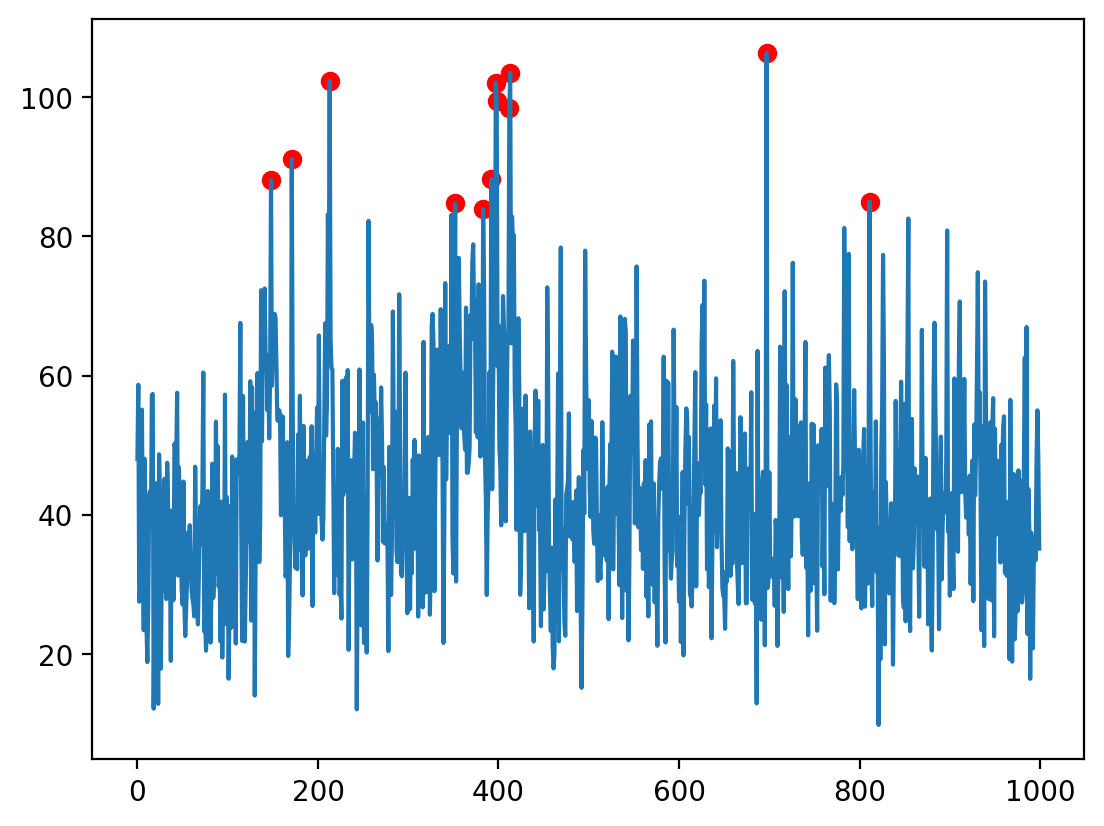

In [97]:
neuron = 206
T = 1000
plt.plot(y_session_interp[:T,neuron])
idx = np.linspace(0,T-1,T)
spiking_neuron = spiking[:T,neuron]
y_out = y_session_interp[0:T,neuron].copy()
y_out = y_out * spiking_neuron #0 out non-spikes, times 1 for spiking activity
y_out[y_out == 0] = np.nan
plt.scatter(idx,y_out,color='r')  
plt.show()

****Train Model****

In [98]:
def to_np(tens):
    return tens.detach().cpu().numpy()

def filter_indices_with_lags(train_data_index, num_lags):
    train_indices = []
    val_indices = []
    # Iterate through the train_data_index with a buffer zone of num_lags
    for i in range(len(train_data_index) - num_lags):
        # Check if the current index and all the next num_lags indices are the same
        if all(train_data_index[i + j] == 1 for j in range(num_lags + 1)):
            train_indices.append(i)
        elif all(train_data_index[i + j] == 0 for j in range(num_lags + 1)):
            val_indices.append(i)
    
    return train_indices, val_indices

def split_dataset(dataset, train_data_index, num_lags):
    train_indices, val_indices = filter_indices_with_lags(train_data_index, num_lags)
    
    # Create subsets for training and validation
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    return train_subset, val_subset

In [99]:
# linear model + torch gradient descent
class TimeseriesDataset(Dataset):
    def __init__(self, X, U, num_lags):
        self.X = X
        self.U = U 
        self.num_lags = num_lags

    def __len__(self):
        # The dataset length is reduced by num_lags due to the dependency on previous data points
        return len(self.X) - self.num_lags

    def __getitem__(self, index):
        # Return slices for X and U for the current index adjusted for lags
        X_history = [self.X[index + i] for i in range(self.num_lags)]
        U_history = [self.U[index + i] for i in range(self.num_lags)]
        X_next = self.X[index + self.num_lags]
        return X_history, U_history, X_next
    
#take matrix, clip eigenvalues to a max of 1, reconstruct matrix with clipped eigenvalues
def spectral_projection(matrix):
    # Assuming matrix is square and differentiable
    eigenvalues, eigenvectors = torch.linalg.eig(matrix)
    # Clip the eigenvalues
    clipped_eigenvalues = torch.clamp(eigenvalues.real, max=1)  # only take the real parts, assuming eigenvalues are real
    # Reconstruct the matrix with the modified eigenvalues
    diagonal_matrix = torch.diag(torch.complex(clipped_eigenvalues, torch.zeros_like(clipped_eigenvalues)))
    projected_matrix = eigenvectors @ diagonal_matrix @ eigenvectors.inverse()
    return projected_matrix.real  # assuming the input matrix is real

#normalizes matrix
def singular_value_norm(matrix):
    norm_val = torch.linalg.norm(matrix, 2)  #largest singular value
    if norm_val > 2: 
        matrix = 2 * matrix / norm_val
    return matrix


#??????? match the model to the equation help
class LinearDynamicModel(nn.Module):
    def __init__(self, state_dim, input_dim, num_lags, init_value = None):
        
        super(LinearDynamicModel, self).__init__()
        
        if init_value is None:
            # Create diagonal matrices for alpha and beta, one for each lag
            self.alpha = nn.ParameterList([nn.Parameter(torch.randn(state_dim)) for _ in range(num_lags)])
            self.beta = nn.ParameterList([nn.Parameter(torch.randn(state_dim)) for _ in range(num_lags)])
            
            #W is mat A and B is mat B?
            self.W = nn.ParameterList([nn.Parameter(torch.randn(state_dim, state_dim)) for _ in range(num_lags)])
            self.B = nn.ParameterList([nn.Parameter(torch.randn(state_dim, input_dim)) for _ in range(num_lags)])

            self.V = nn.Parameter(torch.randn(state_dim))
        else:
            # Create diagonal matrices for alpha and beta, one for each lag (s in equation 3.1)
            self.alpha = nn.ParameterList([nn.Parameter(init_value['alpha'][i]) for i in range(num_lags)])
            self.beta = nn.ParameterList([nn.Parameter(init_value['beta'][i]) for i in range(num_lags)])

            self.W = nn.ParameterList([nn.Parameter(init_value['W'][i]) for i in range(num_lags)])
            self.B = nn.ParameterList([nn.Parameter(init_value['B'][i]) for _ in range(num_lags)])

            self.V = nn.Parameter(init_value['V'])
        
    def forward(self, X_history, U_history):
        X_next = torch.zeros_like(X_history[0])
        for W_k, alpha_k, X_k in zip(self.W, self.alpha, X_history):

            # X_k has shape (batch_size, state_dim)
            # Apply W_k to each batch element using batch matrix multiplication
            X_k = X_k.unsqueeze(-1)  # Shape becomes (batch_size, state_dim, 1)
            alpha_diag_k = torch.diag(alpha_k)

            #compute contribution of state X_k to state X_next
            #matrices A and B correspond to W + diag(alpha) and B + diag(beta)
            #??????? Work through dimensions of these calculations
            contribution = torch.matmul(singular_value_norm(W_k + alpha_diag_k), X_k).squeeze(-1)  # Shape returns to (batch_size, state_dim)
            X_next += contribution
        for B_k, beta_k, U_k in zip(self.B, self.beta, U_history):
            U_k = U_k.unsqueeze(-1)
            beta_diag_k = torch.diag(beta_k)
            #compute contribution of input U_k to next state X-next
            contribution = torch.matmul(singular_value_norm(B_k + beta_diag_k), U_k).squeeze(-1)
            X_next += contribution
        X_next += self.V[None, :]
        return X_next
    
class LowRankLinearDynamicModel(nn.Module):
    def __init__(self, state_dim, input_dim, rank_dim, num_lags, init_value = None):
        super(LowRankLinearDynamicModel, self).__init__()
        
        if init_value is None:
            # Create diagonal matrices for alpha and beta, one for each lag
            self.alpha = nn.ParameterList([nn.Parameter(torch.randn(state_dim)) for _ in range(num_lags)])
            self.beta = nn.ParameterList([nn.Parameter(torch.randn(state_dim)) for _ in range(num_lags)])

            self.W_u = nn.ParameterList([nn.Parameter(torch.randn(state_dim, rank_dim)) for _ in range(num_lags)])
            self.W_v = nn.ParameterList([nn.Parameter(torch.randn(state_dim, rank_dim)) for _ in range(num_lags)])

            self.B_u = nn.ParameterList([nn.Parameter(torch.randn(state_dim, rank_dim)) for _ in range(num_lags)])
            self.B_v = nn.ParameterList([nn.Parameter(torch.randn(state_dim, rank_dim)) for _ in range(num_lags)])

            self.V = nn.Parameter(torch.randn(state_dim))
        else:
            # Create diagonal matrices for alpha and beta, one for each lag
            self.alpha = nn.ParameterList([nn.Parameter(init_value['alpha'][i]) for i in range(num_lags)])
            self.beta = nn.ParameterList([nn.Parameter(init_value['beta'][i]) for i in range(num_lags)])

            self.W_u = nn.ParameterList([nn.Parameter(init_value['W_u'][i]) for i in range(num_lags)])
            self.W_v = nn.ParameterList([nn.Parameter(init_value['W_v'][i]) for i in range(num_lags)])

            self.B_u = nn.ParameterList([nn.Parameter(init_value['B_u'][i]) for _ in range(num_lags)])
            self.B_v = nn.ParameterList([nn.Parameter(init_value['B_v'][i]) for _ in range(num_lags)])

            self.V = nn.Parameter(init_value['V'])
        
    def forward(self, X_history, U_history):
        X_next = torch.zeros_like(X_history[0])
        for W_u_k, W_v_k, alpha_k, X_k in zip(self.W_u, self.W_v, self.alpha, X_history):
            # X_k has shape (batch_size, state_dim)
            # Apply W_k to each batch element using batch matrix multiplication
            # ????? Work through dimensions of these calculations
            X_k = X_k.unsqueeze(-1)  # Shape becomes (batch_size, state_dim, 1)
            alpha_diag_k = torch.diag(alpha_k)

            # U_A @ V_A.T
            W_k = torch.mm(W_u_k, W_v_k.T)
            
            #A_s = U_A @ V_A.T + D_A
            #contribution = A_s * x_t-s
            contribution = torch.matmul(singular_value_norm(W_k + alpha_diag_k), X_k).squeeze(-1)  # Shape returns to (batch_size, state_dim)
            X_next += contribution
        for B_u_k, B_v_k, beta_k, U_k in zip(self.B_u, self.B_v, self.beta, U_history):
            U_k = U_k.unsqueeze(-1)
            beta_diag_k = torch.diag(beta_k)

            # U_B @ V_B.T
            B_k = torch.mm(B_u_k, B_v_k.T)
            
            #B_s = U_B @ V_B.T + D_B
            #contribution = B_s * u_(t-s)
            contribution = torch.matmul(singular_value_norm(B_k + beta_diag_k), U_k).squeeze(-1)
            X_next += contribution
        X_next += self.V[None, :]
        return X_next

def train_model(model, train_loader, val_loader, epochs=100, lr=0.01, clip_value=1.0, l1_lambda=0.01, step_size=50, gamma=0.5, checkpoint_name = 'linear_35'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)  # Learning rate scheduler
    criterion = nn.MSELoss()
    best_val_loss = float('inf')
    
    # Lists to track loss
    train_losses = []
    val_losses = []
    l1_penalty_losses = []
    
    current_lr = lr

    for epoch in range(epochs):
        # Training Phase
        model.train()
        total_train_loss = 0
        total_l1_penaty = 0

        for X_history, U_history, X_next in train_loader:
            optimizer.zero_grad()
            predictions = model(X_history, U_history)
            loss = criterion(predictions, X_next)
            
            total_train_loss += loss.item()
            
            # Compute the L1 penalty for each parameter
            l1_penalty = torch.tensor(0.).to(device)
            
            # Add the L1 penalty to the original loss
            loss += l1_lambda * l1_penalty
            
            total_l1_penaty += l1_penalty.item()
            
            loss.backward()
            optimizer.step()
        
        # Validation Phase
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for X_history, U_history, X_next in val_loader:
                predictions = model(X_history, U_history)
                loss = criterion(predictions, X_next)
                total_val_loss += loss.item()

        # Logging training and validation loss
        train_loss = total_train_loss / len(train_loader)
        val_loss = total_val_loss / len(val_loader)
        l1_penaty_loss = total_l1_penaty / len(train_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        l1_penalty_losses.append(l1_penaty_loss)
        
        print(f'Epoch {epoch}: Train Loss = {train_loss}, Val Loss = {val_loss}, L1 Penalty Loss = {l1_penaty_loss}, LR = {current_lr}')

        # Checkpointing based on minimal validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            Path("checkpoints").mkdir(exist_ok=True)
            checkpoint_path = f'checkpoints/model_best_' + checkpoint_name + '.pt'
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch} with Val Loss: {val_loss:.4f}")
            
    # Plotting the training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')  #if no x provided, plots against indices
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plotting the L1 penalties
    plt.figure(figsize=(10, 5))
    plt.plot(l1_penalty_losses, label='L1 Penalty', color='red')
    plt.title('L1 Penalty Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('L1 Penalty')
    plt.legend()
    plt.grid(True)
    plt.show()

In [130]:
def low_rank_diagnol_preservation_approximation(A, r):
    # Perform Singular Value Decomposition
    A_r = A - np.diag(np.diag(A))  #A_r is just A w/ diagonal elements set to 0
    U, s, Vt = np.linalg.svd(A_r, full_matrices=False)
    # Keep only the top r singular values (and corresponding vectors)
    Ur = U[:, :r]  #first r columns of U
    Sr = np.diag(s[:r])  # Create a diagonal matrix of the top r singular values
    Vtr = Vt[:r, :]  #first r rows of Vt
    # Reconstruct the low-rank approximation of the matrix
    Ar = np.dot(Ur, np.dot(Sr, Vtr))
    return Ar + np.diag(np.diag(A))  #??????? Why do we remove and add back the original diagonal elements


def low_rank_svd_components_approximation(A, r):
    # Perform Singular Value Decomposition
    A_r = A - np.diag(np.diag(A))
    U, s, Vt = np.linalg.svd(A_r, full_matrices=False)
    # Keep only the top r singular values (and corresponding vectors)
    Ur = U[:, :r]
    Sr = np.diag(s[:r])  # Create a diagonal matrix of the top r singular values
    Vtr = Vt[:r, :]
    # Reconstruct the low-rank approximation of the matrix
    Ar = np.dot(Ur, np.dot(Sr, Vtr))
    return np.diag(A), Ur, np.dot(Sr, Vtr).T, Ar

def diag_off_diag_extraction(A):
    # Perform Singular Value Decomposition
    A_r = A - np.diag(np.diag(A))
    return np.diag(A), A_r


#?????? is this the causal connectivity matrix? H?
#****ASK ANDREW WAGENMAKER
#iteratively apply system's dynamics in A and B params over number of steps
#'rollout_len'. Average the resulting matrices over many iterations, to
#provide a robust estimate of system's average connectivity matrix
def compute_transfer_matrix(Ahat):
    k = 4
    avg_connect_ark = np.zeros((d,d))
    rollout_len = 1000  #1000 is enough for ss
    params = []
    A_params = []
    B_params = []
    for i in range(k):
        params.append(np.zeros((d,d)))
        A_params.insert(0,Ahat[:,i*d:(i+1)*d])
        B_params.insert(0,Ahat[:,d*k+i*d:d*k+(i+1)*d])

    for t in range(rollout_len):
        param_new = np.zeros((d,d))
        for i in range(k):
            param_new += A_params[i] @ params[i]
        if t <= k-1:
            param_new += B_params[t]
        params = params[:-1]
        params.insert(0,param_new)
        avg_connect_ark += params[0]
    return avg_connect_ark

#plot singular values of diagonals removed np.diag(A) A and regular A
def plot_rank_svd(A):
    A2 = A - np.diag(np.diag(A))
    U_true,S_true,V_true = la.svd(A2)
    plt.plot(S_true,label='A-diag')
    plt.xlabel('singular value index')
    plt.ylabel('singular value')

    U_true,S_true,V_true = la.svd(A)
    plt.plot(S_true,label='full A')
    plt.xlabel('singular value index')
    plt.ylabel('singular value')

    plt.legend()
    plt.show()
    # print(S_true)

In [113]:
print(len(train_indices)) #same as t
print(train_indices.shape[0])

y_session_interp[1+ark_order,:].shape

29402
29402


(507,)

In [102]:
#???????? quick summary together
# linear model + closed form
ark_order = 4  #number of past observations used to predict current value of model
normalize = 1000
X = []
Xp = []
for t in range(train_indices.shape[0]-ark_order):
    if np.sum(train_indices[t:t+ark_order+1]) == ark_order + 1 and t > 5 + ark_order:  #if its valid training data, if they are all 1s
        X.append(np.concatenate((y_session_interp[t:t+ark_order,:].copy().flatten()/normalize, u_session[t:t+ark_order,:].copy().flatten(),np.ones(1)))) 
        Xp.append(y_session_interp[t+ark_order,:].copy().flatten()/normalize)  #neurons response
X = np.array(X)
Xp = np.array(Xp)
Ahat = np.linalg.pinv(X.T @ X) @ X.T @ Xp
#Ahat --> A, B, v, everything  
#closed-form solution for linear regression
Ahat = Ahat.T #????????what is Ahat in the paper

In [103]:
# ?????????
# linear model + gradient descent + full rank
x_pred = []
x_true = []
u_true = []
r2 = [] 
idx = -1
ark_order = 4
normalize = 1000
new_segment = True
segment_pred = []
segment_start = -1
for t in range(train_indices.shape[0]):  #29402, same as t
    if test_indices[t] == 1:  #if it is in test set
        if new_segment:
            segment_pred = []
            new_segment = False
            segment_start = t
            x_past = []
            x_pred.append([])
            x_true.append([])
            u_true.append([])
            idx += 1
        if t < segment_start + ark_order:  #if current time step is within first 'ark_order" steps of segment
            x_past.append(y_session_interp[t,:].copy().flatten()/normalize)  #append neuron response at t to x_past
        
        #if not new_segment, and if t is outside current segment
        else:
            z = np.array(x_past).flatten()
            #concat x_past with u_session t interval data for all neurons
            z = np.concatenate((z,u_session[t-ark_order:t,:].copy().flatten(),np.ones(1)))
            
            #use this the x_past/z concatted with u_session t interval data 
            #to predict x_next with A,hat the linear model weights
            x_next = Ahat @ z
            x_past.pop(0) #pop oldest value
            x_past.append(x_next.copy()) #append the new predicted value
            x_pred[idx].append(x_next.copy()) #append predicted value to x_pred
            x_true[idx].append(y_session_interp[t,:].copy().flatten()/normalize)
            u_true[idx].append(u_session[t,:].copy().flatten())
    else: #if current t is not part of test set, a new segment should start
        new_segment = True

mse_losses = []
for i in range(len(x_pred)):
    x_pred[i] = np.array(x_pred[i])
    x_true[i] = np.array(x_true[i])
    u_true[i] = np.array(u_true[i])
    mse_losses.append((np.square(x_pred[i] - x_true[i])).mean())
    r2.append(r2_score(x_true[i],x_pred[i]))
print('mse:', sum(mse_losses)/len(mse_losses))
print('r2:', sum(r2)/len(r2))

#R2 = 1 means model explains 100% of variance of data, 0 means it explains 0 of the variance

mse: 0.0004614665142472525
r2: -0.038431108155198936


In [119]:
print(len(x_true)) #84 segments
print(x_true[1].shape) #(109, 507) second segment in x_true has 109 time steps
print(x_true[1][:,1].shape)

84
(109, 507)
(109,)


In [107]:
tpr = []
fpr = []
thresholds = np.linspace(-2,5,15)

for thresholds_idx in range(len(thresholds)):
    tp_total = 0
    fp_total = 0
    p_total = 0
    n_total = 0

    for neuron in range(u_session.shape[1]): #507 neurons
        output_pred = []
        output_true = []
        for i in range(len(x_true)): #for each of the i segments
            #extend by segment i and neuron's neuron data (109,) 
            #109 elements in this particular segment
            output_pred.extend(x_pred[i][:,neuron]) 
            output_true.extend(x_true[i][:,neuron])

        #expect output_pred to have 109 + x + x1 + .... time steps
        output_pred = np.array(output_pred)
        output_true = np.array(output_true)
    
        mean_threshold = np.median(output_true)
        lower_tail_idx = (output_true < mean_threshold)
        lower_tail_data = output_true[lower_tail_idx]
        lower_tail_std = np.std(lower_tail_data)
        true_spike_threshold = mean_threshold + 6*lower_tail_std
        #new detect_spike_threshold per each threshold in our list at the top
        detect_spike_threshold = mean_threshold + thresholds[thresholds_idx]*lower_tail_std

        # ??????? confused why we are just setting predicted spikes to have a lower
        # detect_spike_threshold than true_spike_threshold?
        predicted_spikes = (output_pred > detect_spike_threshold)
        true_spikes = (output_true > true_spike_threshold)
        tp_total += np.sum(np.logical_and(predicted_spikes,true_spikes))
        fp_total += np.sum(np.logical_and(predicted_spikes,~true_spikes))
        p_total += np.sum(true_spikes)
        n_total += np.sum(~true_spikes)

    tpr.append(tp_total / p_total)
    fpr.append(fp_total / n_total)



tpr_noninput = []
fpr_noninput = []
thresholds = np.linspace(-2,5,15)

for thresholds_idx in range(len(thresholds)):
    tp_total = 0
    fp_total = 0
    p_total = 0
    n_total = 0

    for neuron in range(u_session.shape[1]):
        output_pred = []
        output_true = []
        for i in range(len(x_true)): #for each of i segments
            #KEY DIFF: if this neuron was unexcited, then do all same
            if np.sum(u_true[i][:,neuron]) == 0:
                output_pred.extend(x_pred[i][:,neuron])
                output_true.extend(x_true[i][:,neuron])
        output_pred = np.array(output_pred)
        output_true = np.array(output_true)
    
        mean_threshold = np.median(output_true)
        lower_tail_idx = (output_true < mean_threshold)
        lower_tail_data = output_true[lower_tail_idx]
        lower_tail_std = np.std(lower_tail_data)
        true_spike_threshold = mean_threshold + 6*lower_tail_std
        detect_spike_threshold = mean_threshold + thresholds[thresholds_idx]*lower_tail_std

        predicted_spikes = (output_pred > detect_spike_threshold)
        true_spikes = (output_true > true_spike_threshold)
        tp_total += np.sum(np.logical_and(predicted_spikes,true_spikes))
        fp_total += np.sum(np.logical_and(predicted_spikes,~true_spikes))
        p_total += np.sum(true_spikes)
        n_total += np.sum(~true_spikes)

    tpr_noninput.append(tp_total / p_total)
    fpr_noninput.append(fp_total / n_total)
    
results = {}
results['fpr'] = fpr
results['tpr'] = tpr
results['fpr_noninput'] = fpr_noninput
results['tpr_noninput'] = tpr_noninput
np.save('results/results_full.npy', results)

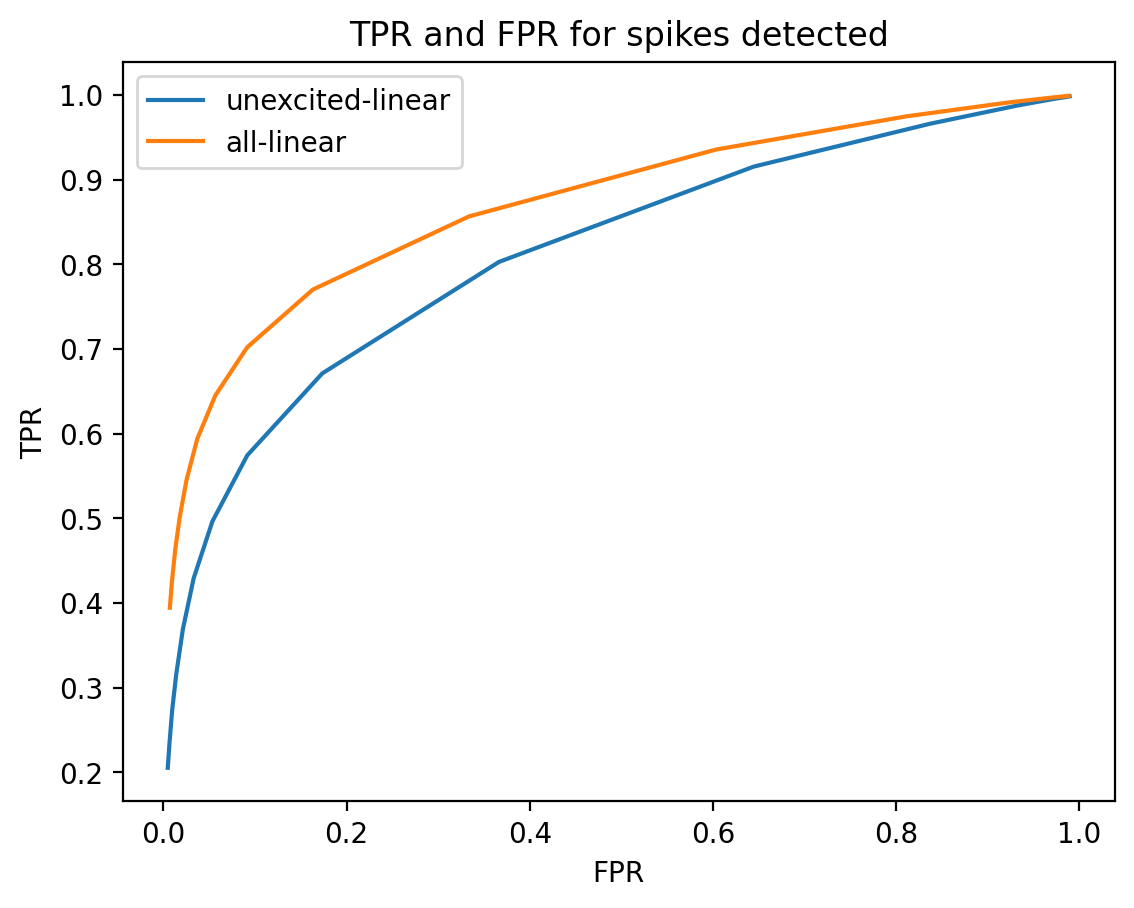

In [120]:
results_load = np.load('results/results_full.npy', allow_pickle=True).item()

# full data linear model vs non-input neurons only
plt.plot(results_load['fpr_noninput'],results_load['tpr_noninput'],label='unexcited-linear')
plt.plot(results_load['fpr'],results_load['tpr'],label='all-linear')
plt.title('TPR and FPR for spikes detected')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

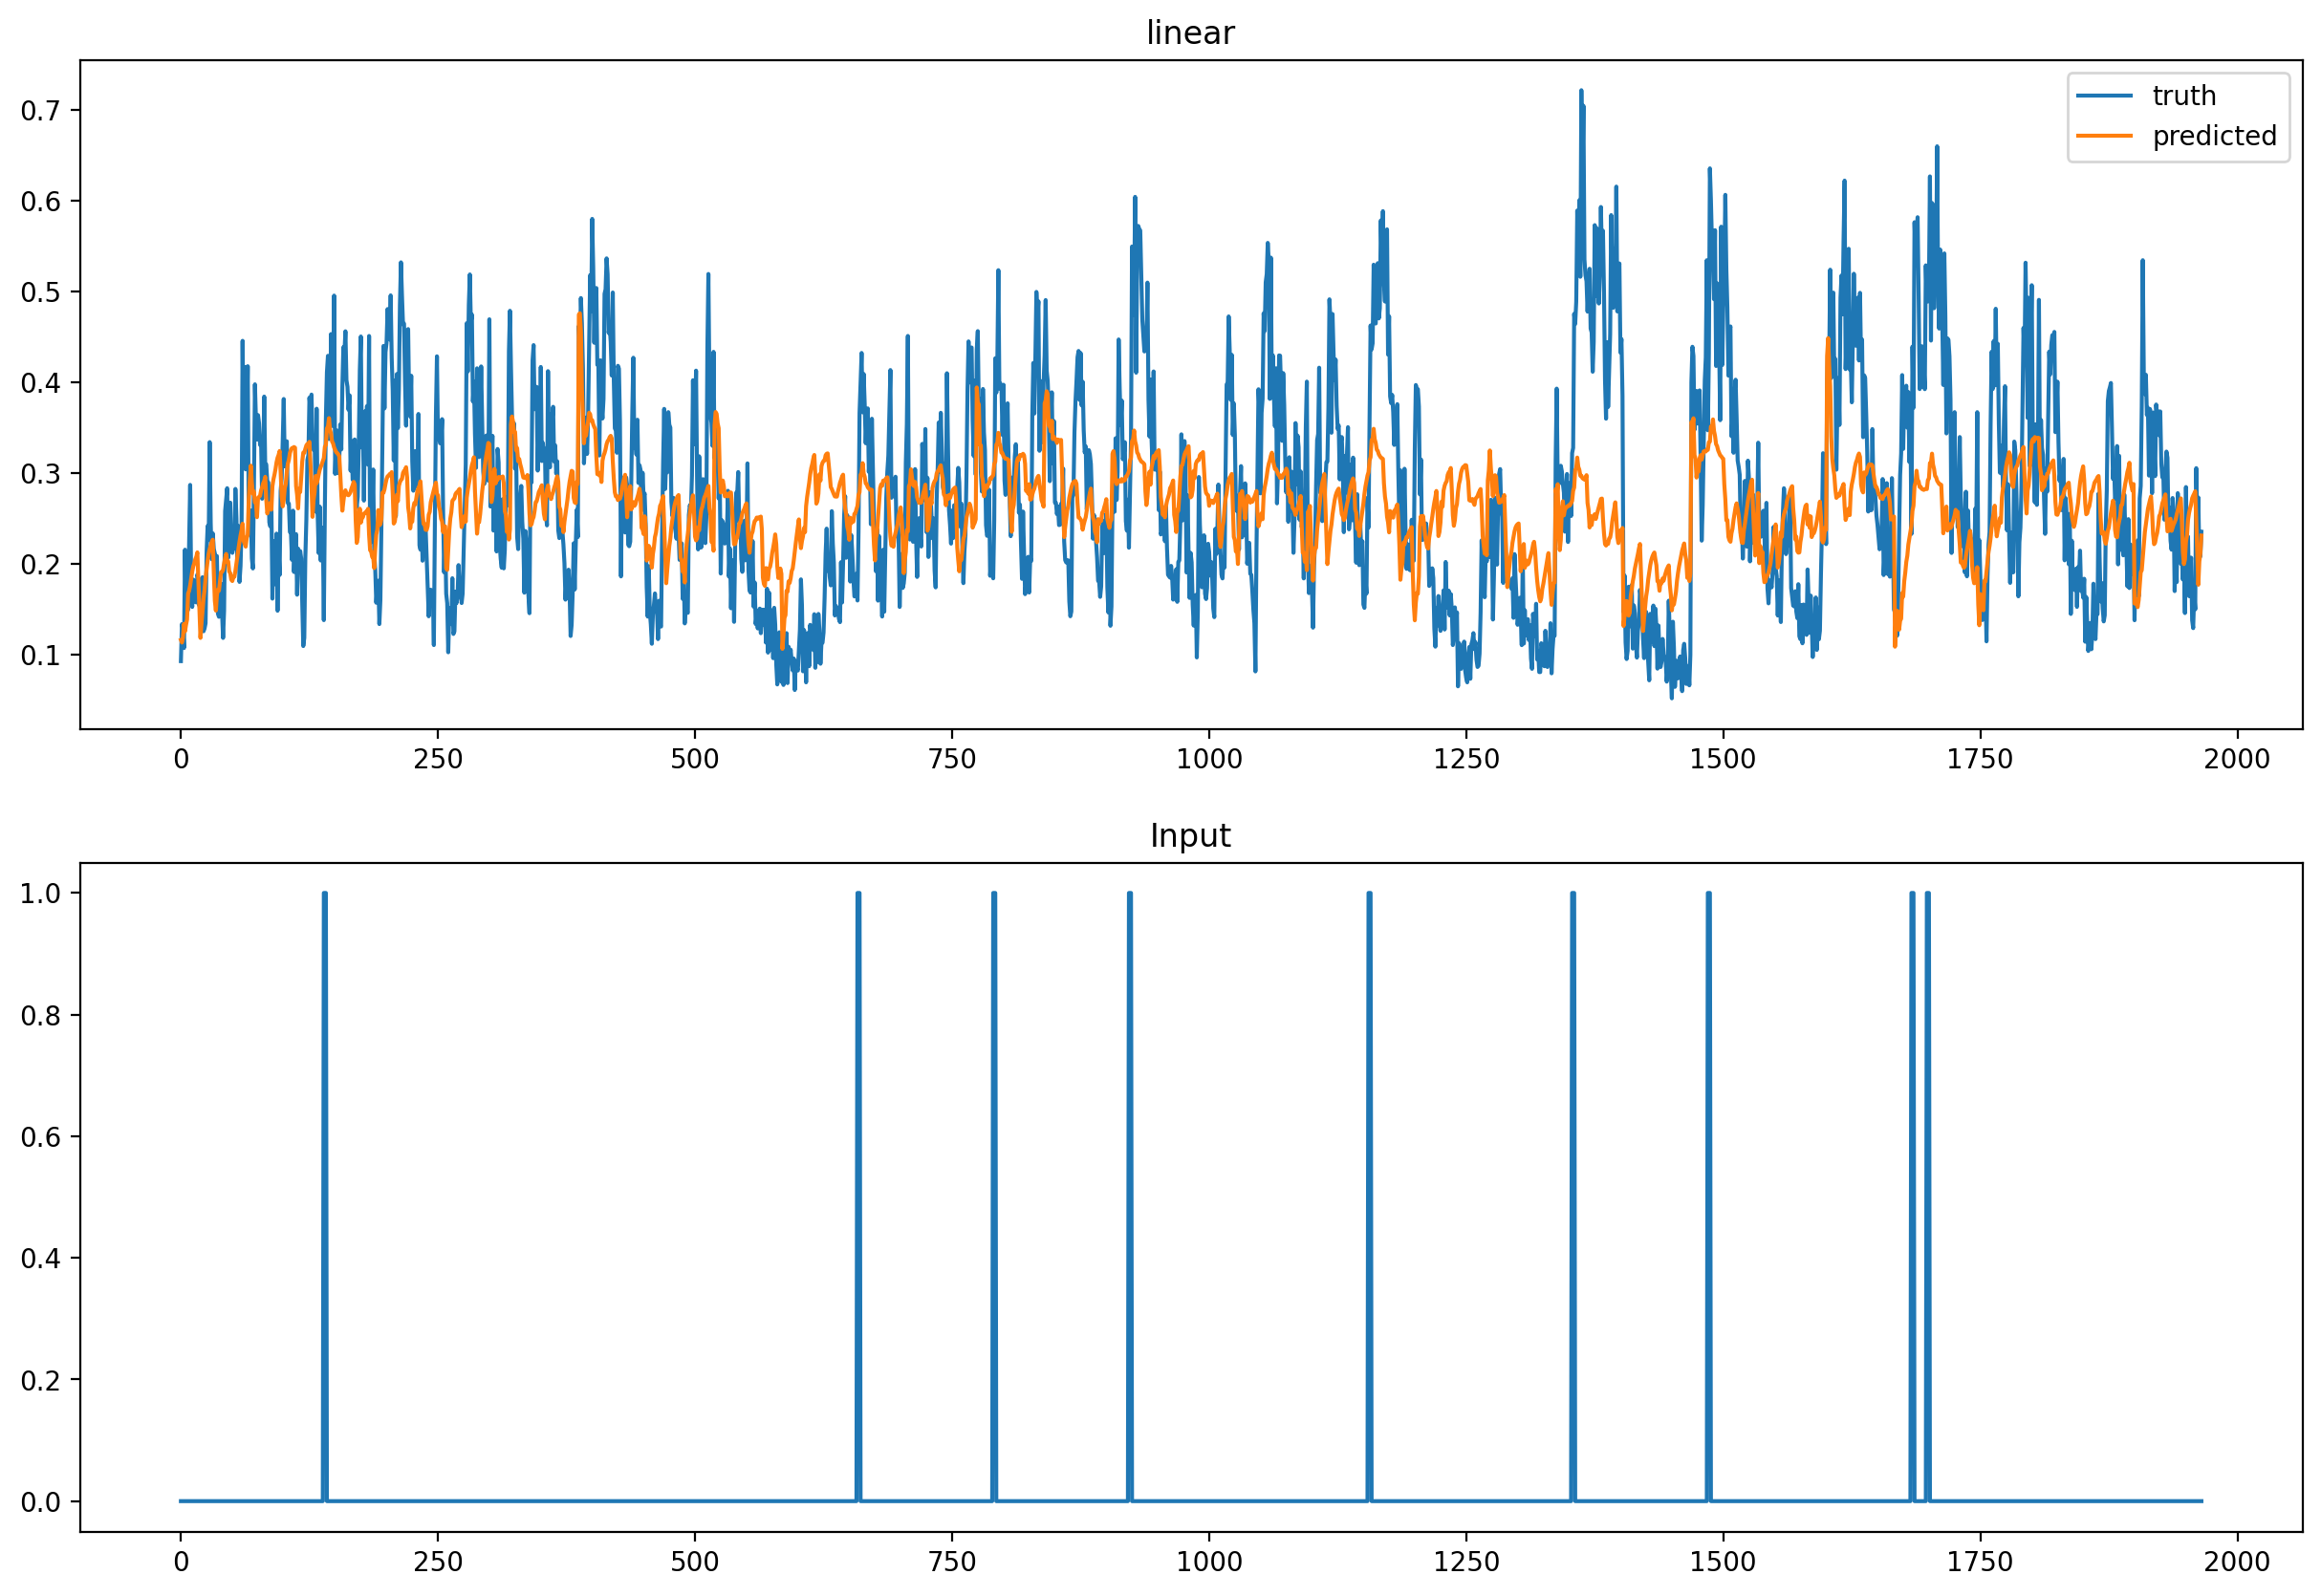

In [121]:
# linear model
neuron = removed_neurons[9]
length = 50
t_start = 30

win_len = 25 #window of segments to observe, segments are the test set

output_pred = []
output_true = []
input_true = []
segment_marker = []

for i in range(t_start, t_start + win_len):
    #add all segment's in the interval's neuron data 
    output_pred.extend(x_pred[i][:,neuron]) #segment i, neuron neuron's predicted data
    #roughly 109 *25, it roughly adds up

    #?????Why are we randomly stitching together the test set through segments
    #and adding their responses into one thing? So these responses did not actually
    #happen linearly in time, correct?????
    output_true.extend(x_true[i][:,neuron])
    input_true.extend(u_true[i][:,neuron])
    segment_marker.extend(np.nan*np.zeros(len(x_pred[i][:,neuron])-1))
    segment_marker.extend([0.25,0]) #add 0.25 followed by 0 to mark end of segment
    
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(output_true,label='truth')
plt.plot(output_pred,label='predicted')
#plt.plot(segment_marker)
plt.title('linear')
plt.legend()

plt.subplot(2,1,2)
plt.plot(input_true,label='input')
plt.title('Input')
plt.savefig('results/full_AR_K.pdf')

In [124]:
print(segment_marker)
print(len(segment_marker))

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.25, 0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.25, 0, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

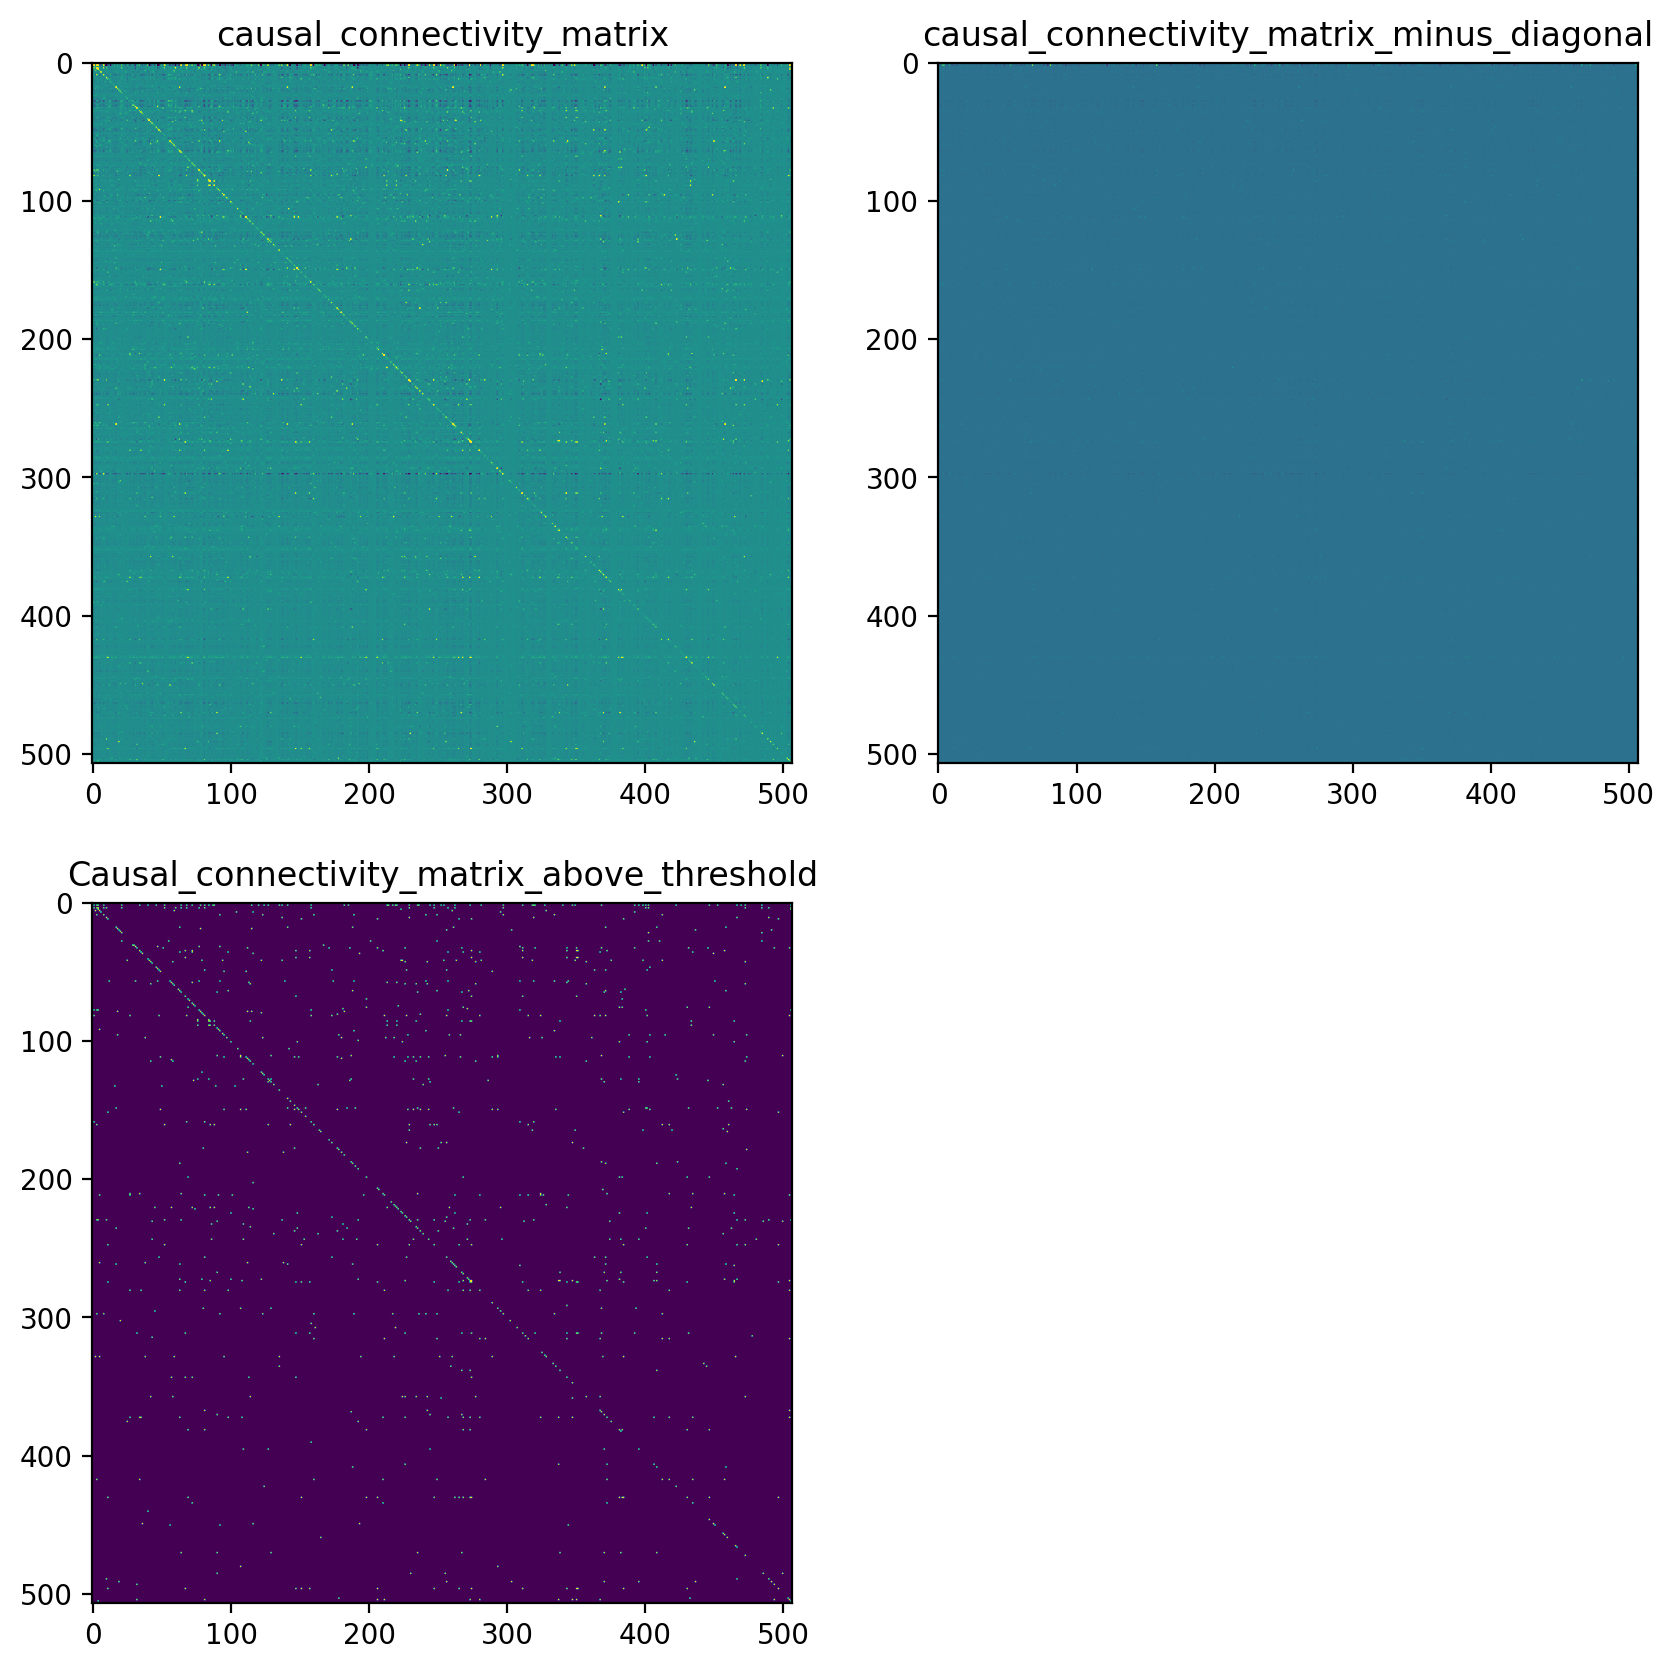

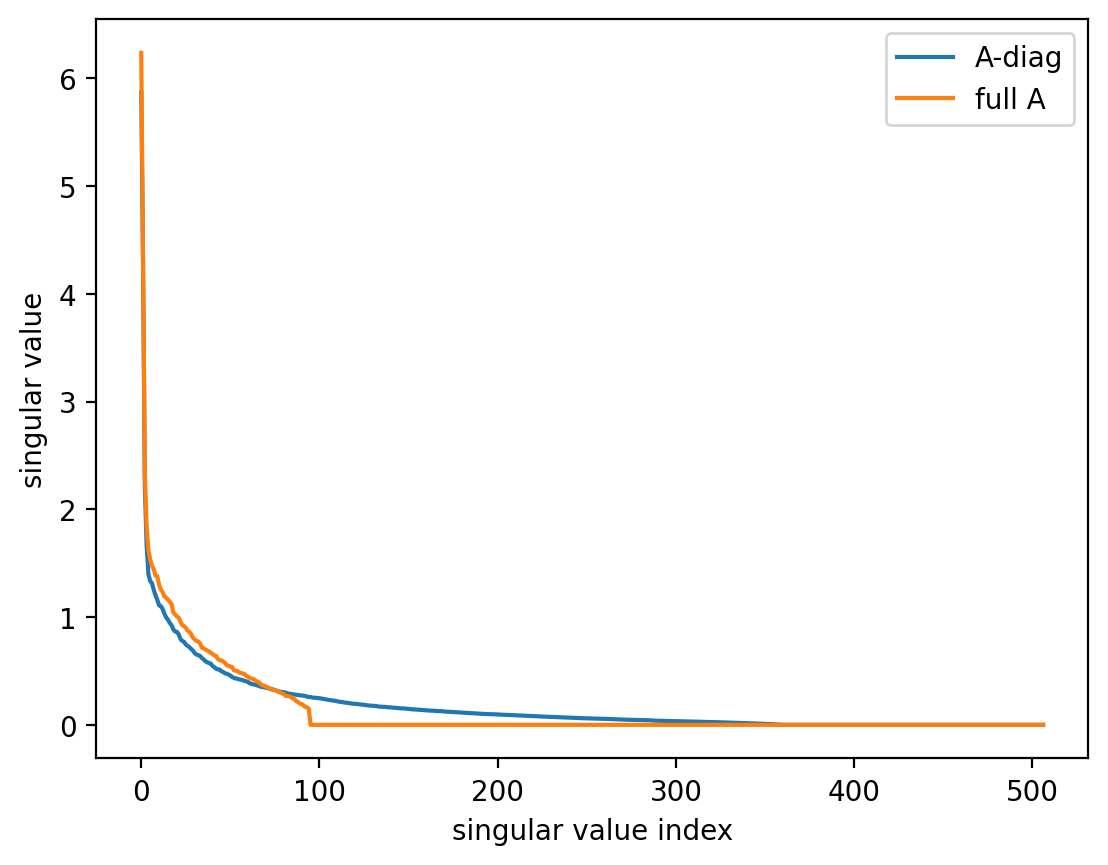

In [131]:
num_neurons = 507
d = num_neurons
A = compute_transfer_matrix(Ahat) #causal connectivity matrix
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('causal_connectivity_matrix')
plt.imshow(A)
plt.clim([-0.2, 0.2])

plt.subplot(2,2,2)
plt.title('causal_connectivity_matrix_minus_diagonal')
plt.imshow(A - np.diag(np.diag(A))) #connectiity matrix - its diagonal

#mean of the largest singular values is used to determine connection coefficient
connection_threshold = 1*np.mean(np.diag(A)) 
A_threshold = (A > connection_threshold).astype(float)
plt.subplot(2,2,3)
plt.title('Causal_connectivity_matrix_above_threshold')
plt.imshow(A > connection_threshold)
plt.figure()
plot_rank_svd(A)

#blue vs orange plot is singular values of A vs A minus diagonals singular values 

In [132]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_neurons = 507
num_lags = 4
init_value = {}
init_value['alpha'] = []
init_value['W'] = []
init_value['beta'] = []
init_value['B'] = []
for i in range(num_lags):
    diag_alpha, W = diag_off_diag_extraction(
        Ahat[:, num_neurons * (i) :num_neurons * (i+1)]) #507x507 matrix
    diag_beta, B = diag_off_diag_extraction(
        Ahat[:, num_neurons * (i+num_lags) :num_neurons * (num_lags+i+1)]) #507x507
    
    init_value['alpha'].insert(0, torch.tensor(diag_alpha).float().to(device))
    init_value['W'].insert(0, torch.tensor(W).float().to(device))
    
    init_value['beta'].insert(0, torch.tensor(diag_beta).float().to(device))
    init_value['B'].insert(0, torch.tensor(B).float().to(device))

V = Ahat[:, num_neurons * (2*num_lags) :num_neurons * (2*num_lags+1)]
init_value['V'] = torch.squeeze(torch.tensor(V)).float().to(device)

In [148]:
print(Ahat)
print(Ahat.shape)
print(Ahat[:, num_neurons * (i) :num_neurons * (i+1)].shape)
print(Ahat[:, num_neurons * (i+num_lags) :num_neurons * (num_lags+i+1)].shape)
# print(num_lags) #4
# print(len(init_value['alpha'])) #4
# print(len(init_value['beta'])) #4
# print(init_value['beta'][0])
# print(len(init_value['beta'][0]))

[[ 0.00251974  0.00094018  0.00428349 ...  0.00035654  0.
   0.03071991]
 [-0.0062405   0.09632708  0.01957647 ...  0.01294051  0.
   0.01745406]
 [-0.01322744 -0.00023306  0.09970804 ... -0.00023565  0.
   0.02196399]
 ...
 [-0.00824308 -0.00180265 -0.01041132 ... -0.00052626  0.
   0.04917244]
 [ 0.03704278 -0.0058901  -0.00891602 ...  0.01009765  0.
   0.02837348]
 [-0.00639217  0.00262645  0.00385577 ... -0.00047819  0.
   0.03721468]]
(507, 4057)
(507, 507)
(507, 507)


Text(0, 0.5, 'count')

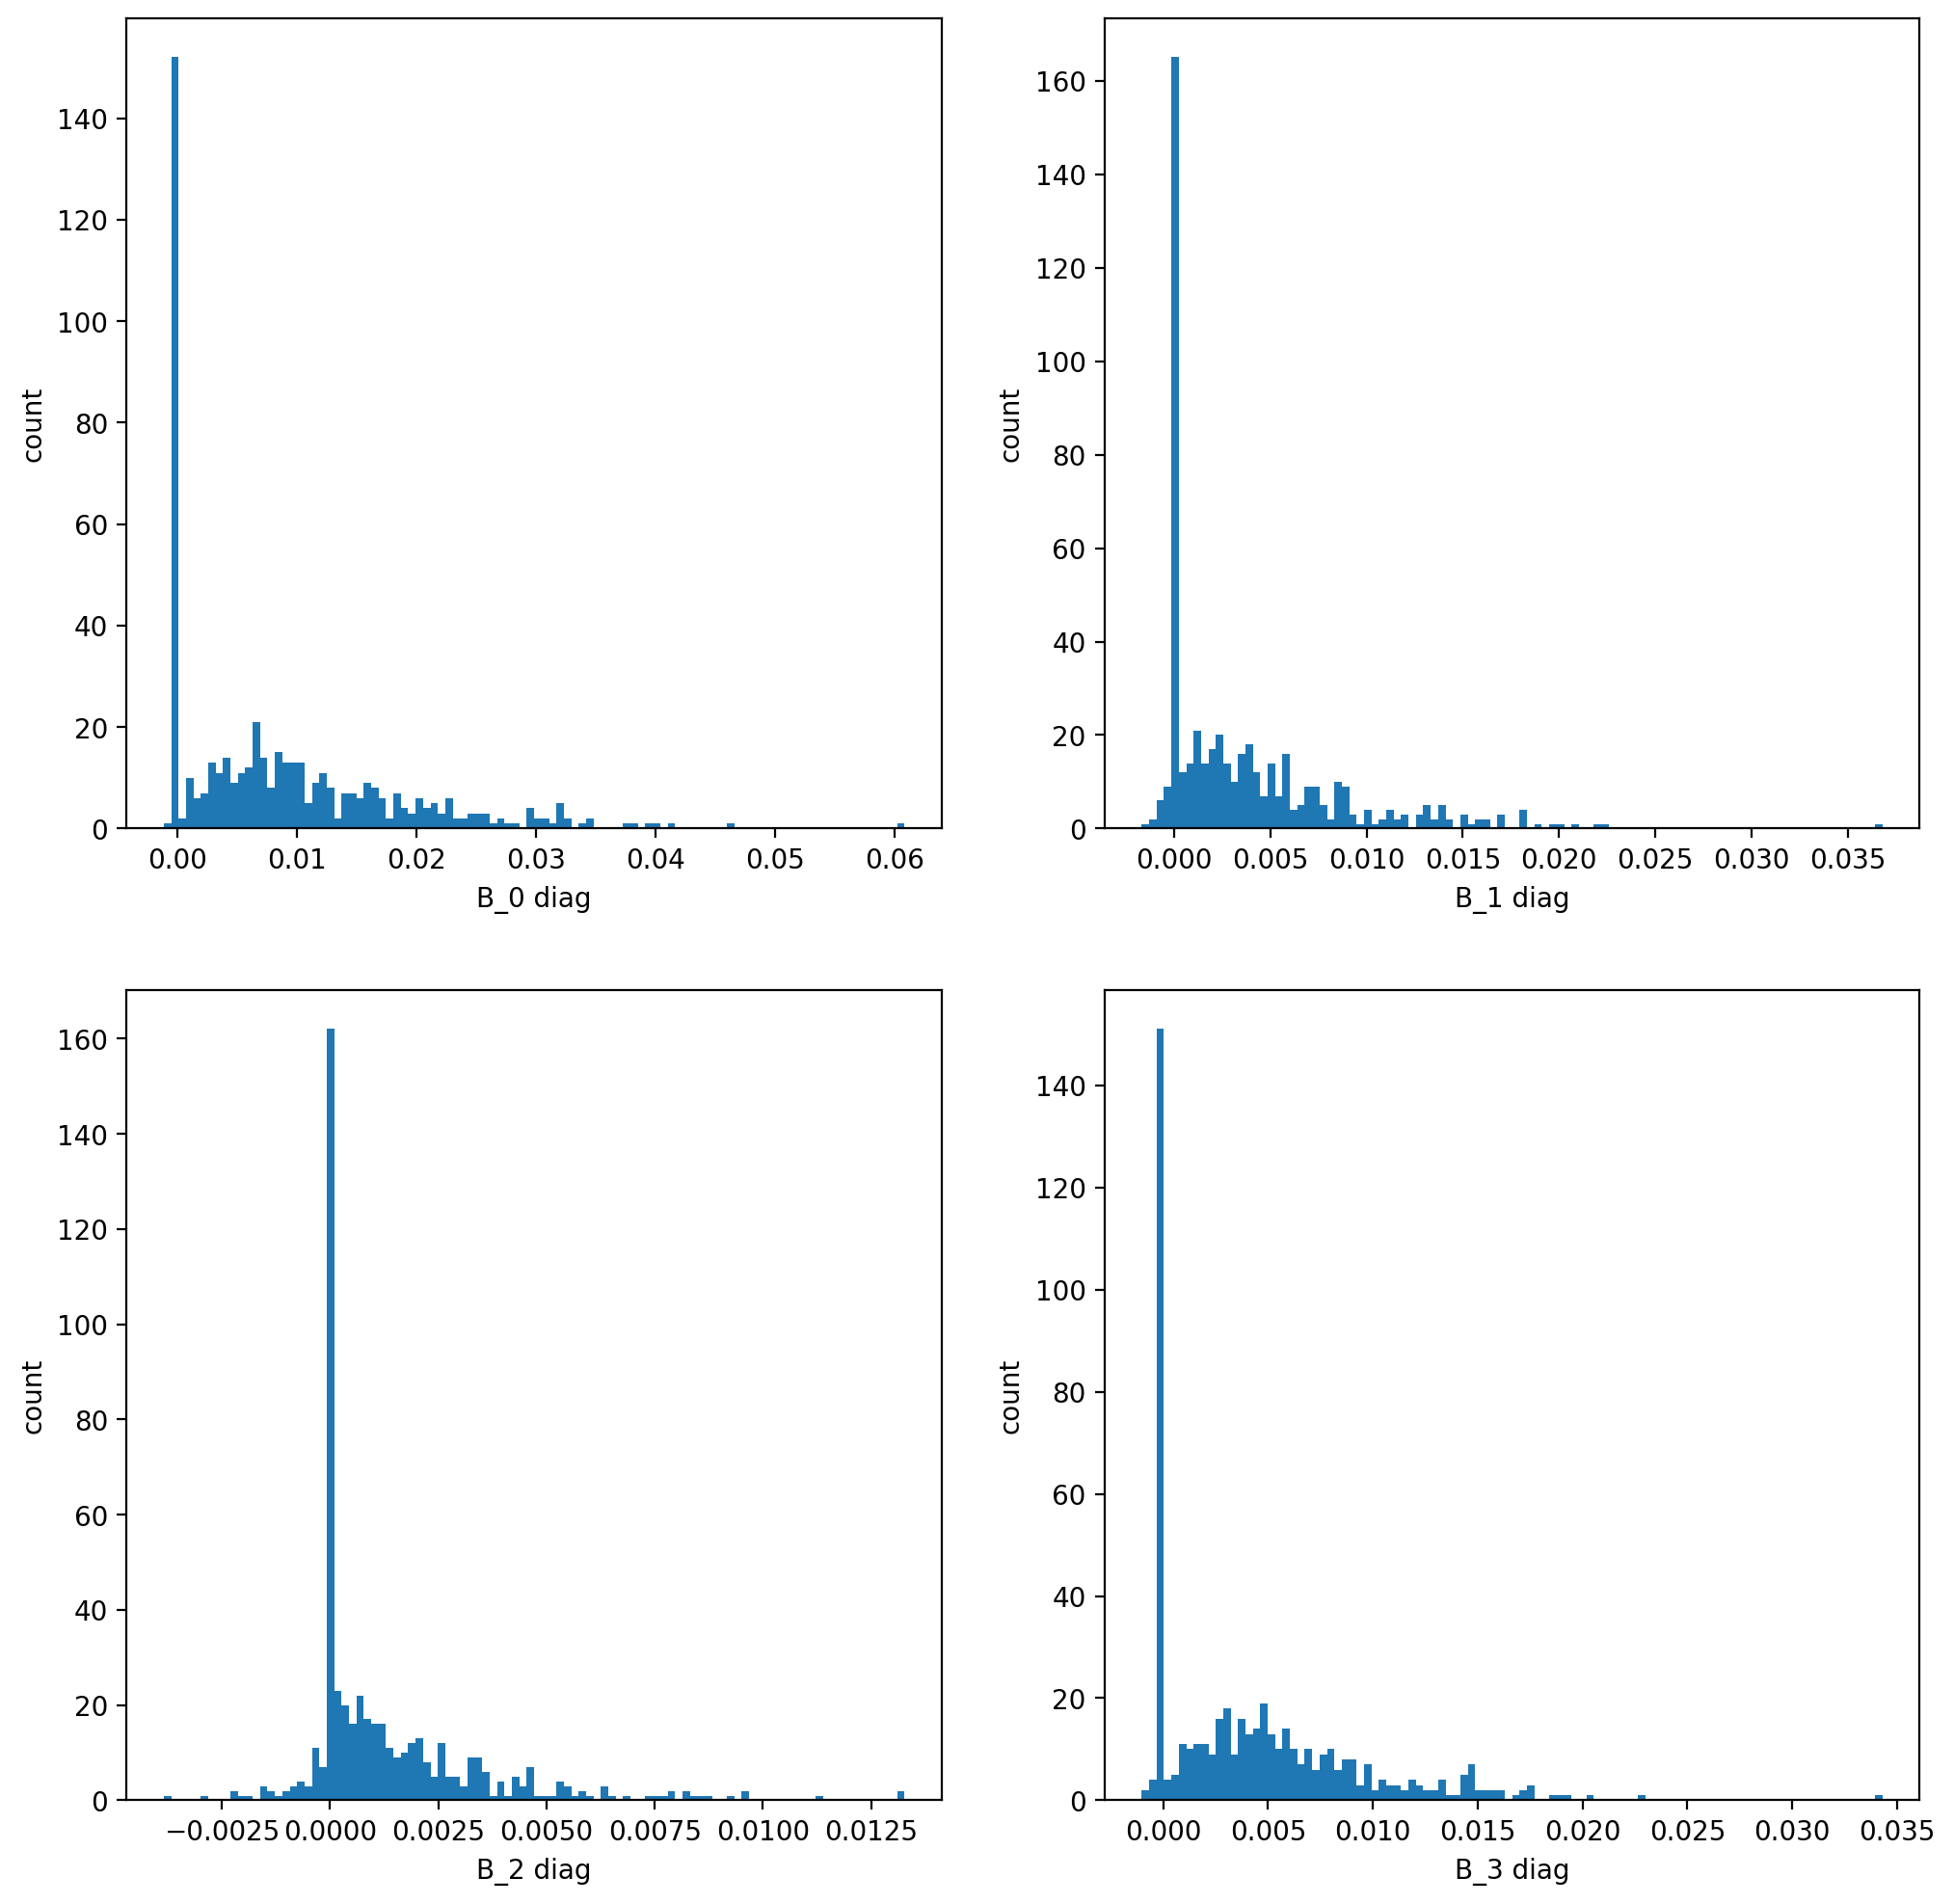

In [139]:
#visualize the distribution of diagonal elements 
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
#graph 507 elements into 100 bins, but why??????? plotting 
#????????need help understanding diag_alpha and diag_beta????????
#???????? further discussion on what is matrix A and what is matrix B????????
plt.hist(to_np(init_value['beta'][0]), bins = 100)
plt.xlabel('B_0 diag')
plt.ylabel('count')
plt.subplot(2,2,2)
plt.hist(to_np(init_value['beta'][1]), bins = 100)
plt.xlabel('B_1 diag')
plt.ylabel('count')
plt.subplot(2,2,3)
plt.hist(to_np(init_value['beta'][2]), bins = 100)
plt.xlabel('B_2 diag')
plt.ylabel('count')
plt.subplot(2,2,4)
plt.hist(to_np(init_value['beta'][3]), bins = 100)
plt.xlabel('B_3 diag')
plt.ylabel('count')

Text(0, 0.5, 'count')

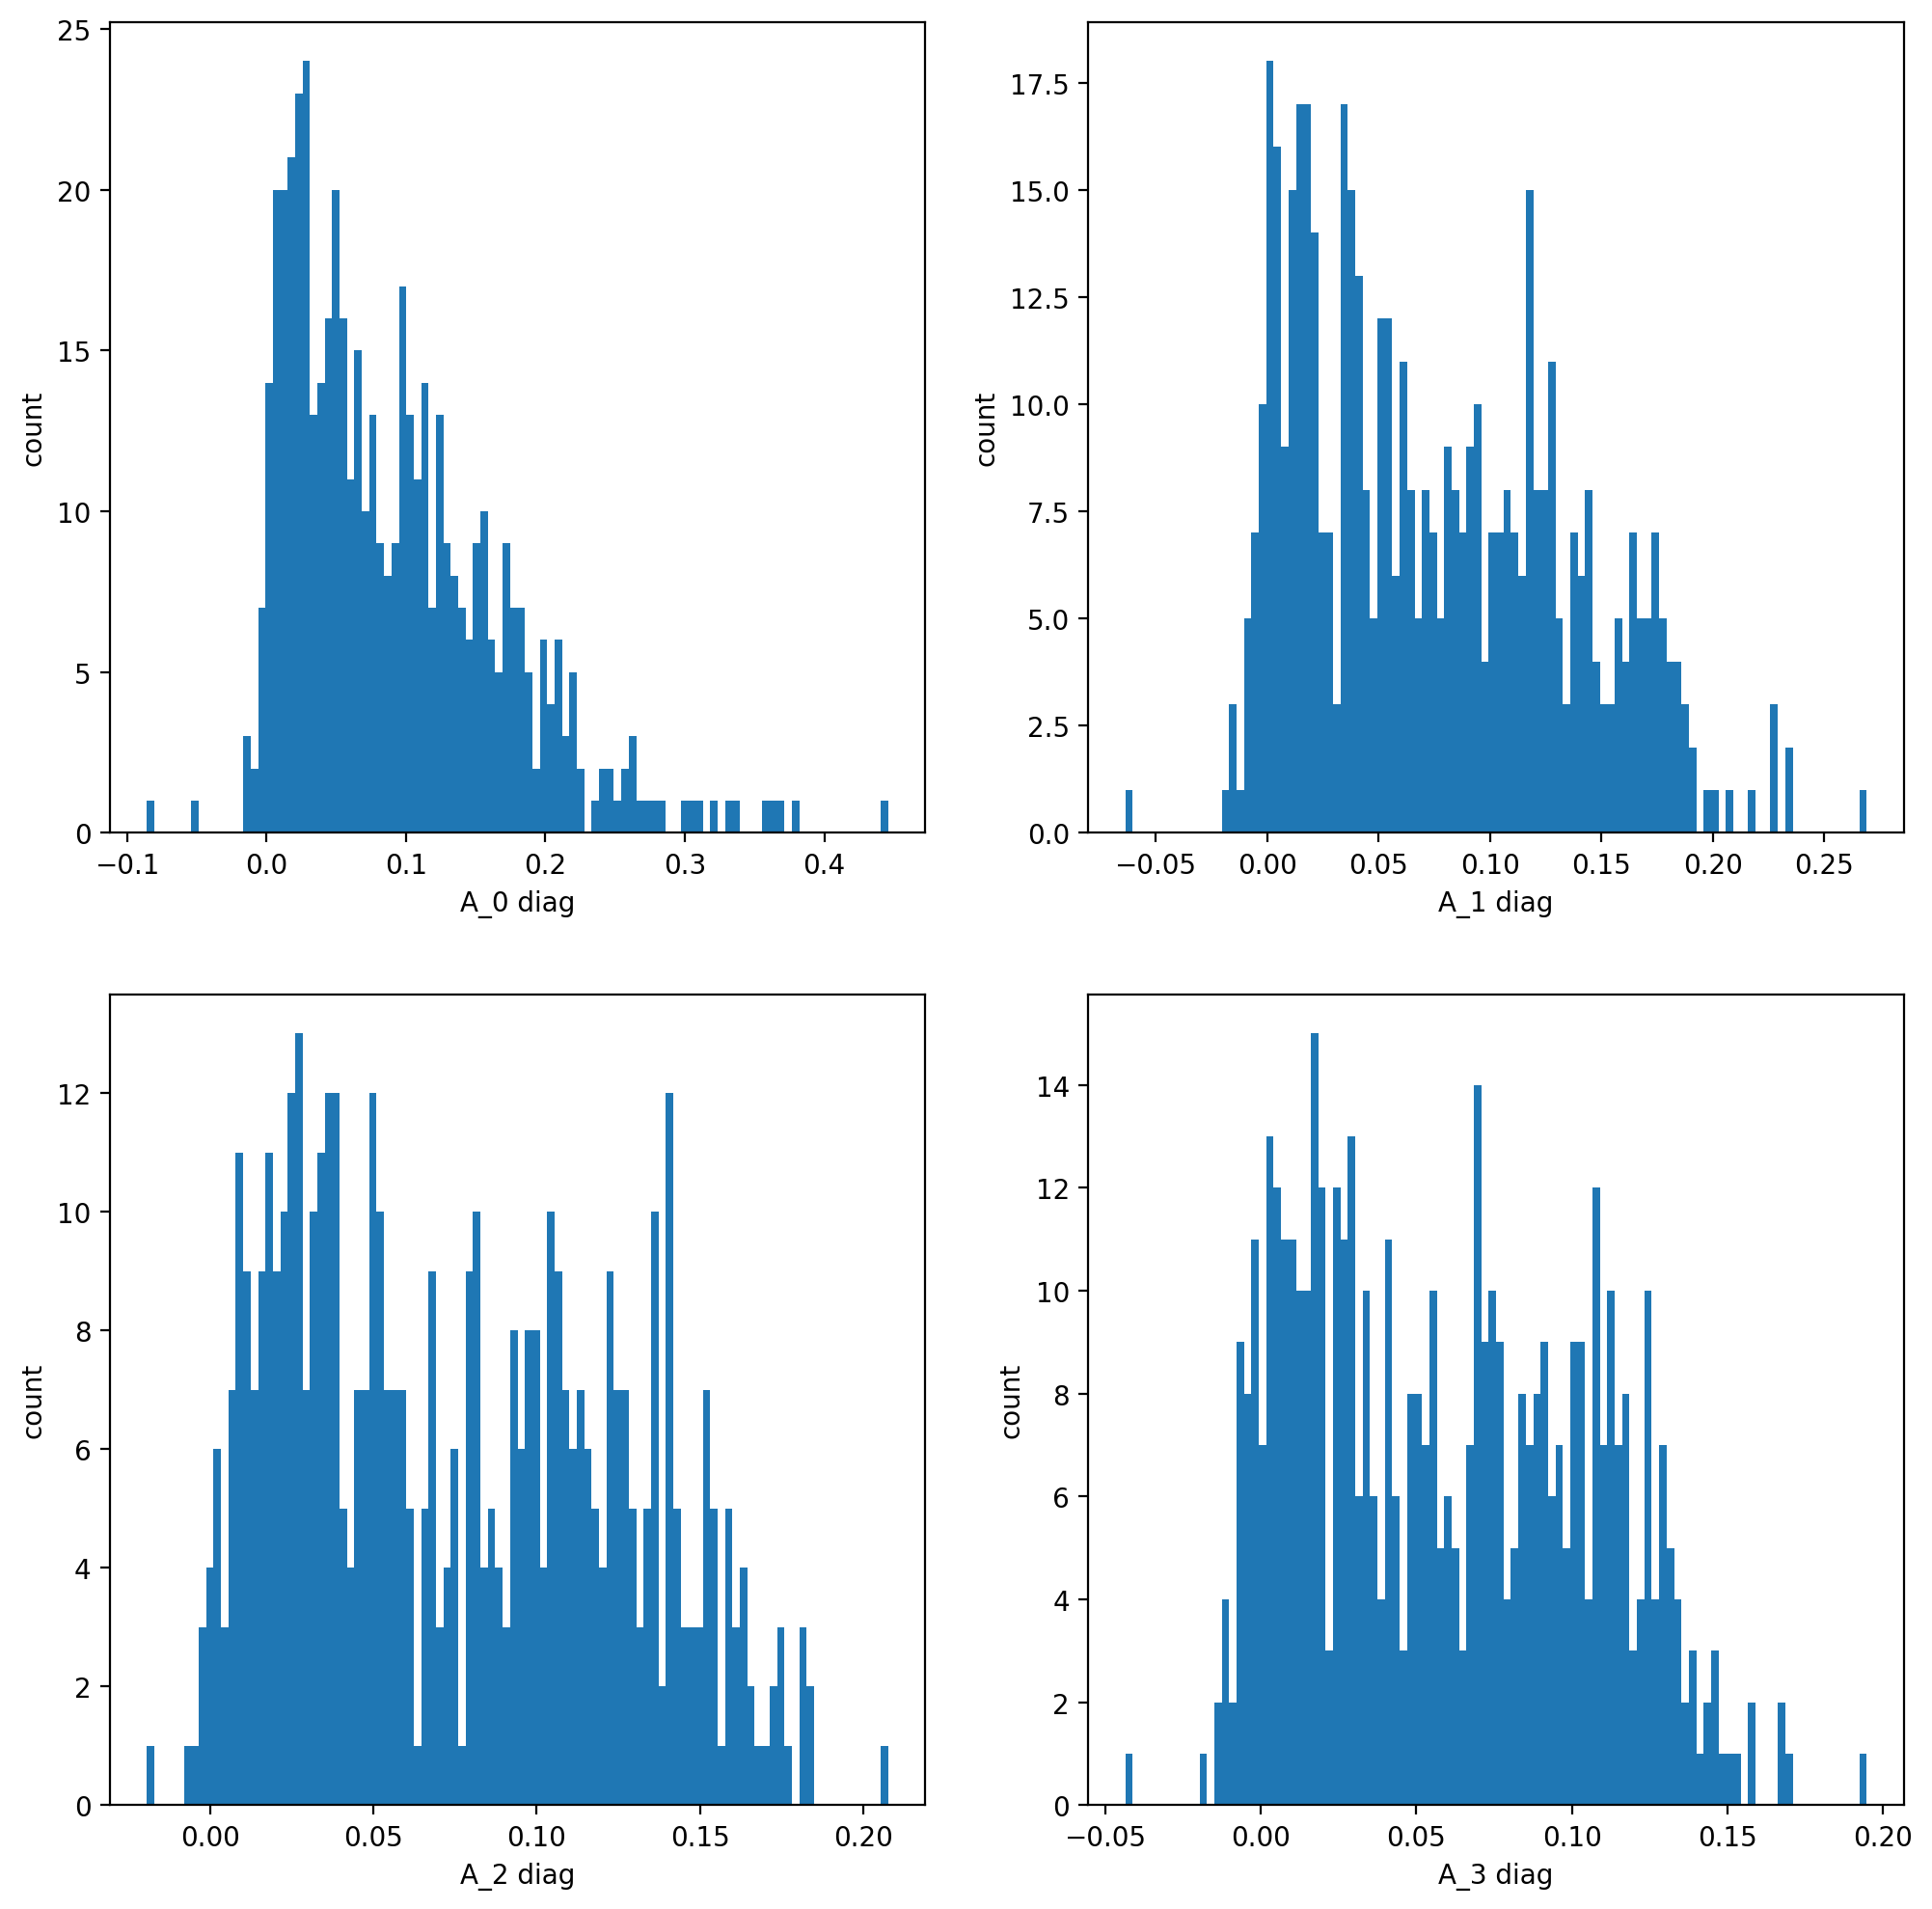

In [142]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.hist(to_np(init_value['alpha'][0]), bins = 100)
plt.xlabel('A_0 diag')
plt.ylabel('count')
plt.subplot(2,2,2)
plt.hist(to_np(init_value['alpha'][1]), bins = 100)
plt.xlabel('A_1 diag')
plt.ylabel('count')
plt.subplot(2,2,3)
plt.hist(to_np(init_value['alpha'][2]), bins = 100)
plt.xlabel('A_2 diag')
plt.ylabel('count')
plt.subplot(2,2,4)
plt.hist(to_np(init_value['alpha'][3]), bins = 100)
plt.xlabel('A_3 diag')
plt.ylabel('count')

In [157]:
#?????????PRIORITY QUESTION: what is Ahat and why are they being sliced 
#differently with the time lag s for matrices W and B?????
# low rank initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_neurons = 507
rank_dim = 5
num_lags = 4
init_value = {}
init_value['alpha'] = []
init_value['W_u'] = []
init_value['W_v'] = []
init_value['beta'] = []
init_value['B_u'] = []
init_value['B_v'] = []
#num_lags is the lag of s historical time steps, s = 0,...,k-1
for i in range(num_lags):
    diag_alpha, Wu, Wv, W_low = low_rank_svd_components_approximation(
        Ahat[:, num_neurons * (i) :num_neurons * (i+1)], rank_dim)
    diag_beta, Bu, Bv, B_low = low_rank_svd_components_approximation(
        Ahat[:, num_neurons * (i+num_lags) :num_neurons * (num_lags+i+1)], rank_dim)
    
    init_value['alpha'].insert(0, torch.tensor(diag_alpha).float().to(device))
    init_value['W_u'].insert(0, torch.tensor(Wu).float().to(device))
    init_value['W_v'].insert(0, torch.tensor(Wv).float().to(device))
    
    init_value['beta'].insert(0, torch.tensor(diag_beta).float().to(device))
    init_value['B_u'].insert(0, torch.tensor(Bu).float().to(device))
    init_value['B_v'].insert(0, torch.tensor(Bv).float().to(device))

V = Ahat[:, num_neurons * (2*num_lags) :num_neurons * (2*num_lags+1)]
init_value['V'] = torch.squeeze(torch.tensor(V)).float().to(device)


In [152]:
train_start = 5
print(len(y_session_interp[train_start:,:]))
print(len(u_session[train_start:,:]))

29397
29397


checkpoint_name: linear_low_rank_5
Epoch 0: Train Loss = 0.000566405962066104, Val Loss = 0.0004598046944011003, L1 Penalty Loss = 0.0, LR = 0.001
Checkpoint saved at epoch 0 with Val Loss: 0.0005
Epoch 1: Train Loss = 0.00041168091411236674, Val Loss = 0.0004126310450374149, L1 Penalty Loss = 0.0, LR = 0.001
Checkpoint saved at epoch 1 with Val Loss: 0.0004
Epoch 2: Train Loss = 0.0003781997293117456, Val Loss = 0.0003913032924174331, L1 Penalty Loss = 0.0, LR = 0.001
Checkpoint saved at epoch 2 with Val Loss: 0.0004
Epoch 3: Train Loss = 0.00036182457066994783, Val Loss = 0.0003786829984164797, L1 Penalty Loss = 0.0, LR = 0.001
Checkpoint saved at epoch 3 with Val Loss: 0.0004
Epoch 4: Train Loss = 0.00035066255562317866, Val Loss = 0.00036866602749796584, L1 Penalty Loss = 0.0, LR = 0.001
Checkpoint saved at epoch 4 with Val Loss: 0.0004
Epoch 5: Train Loss = 0.00034223251229074475, Val Loss = 0.000361553393304348, L1 Penalty Loss = 0.0, LR = 0.001
Checkpoint saved at epoch 5 with V

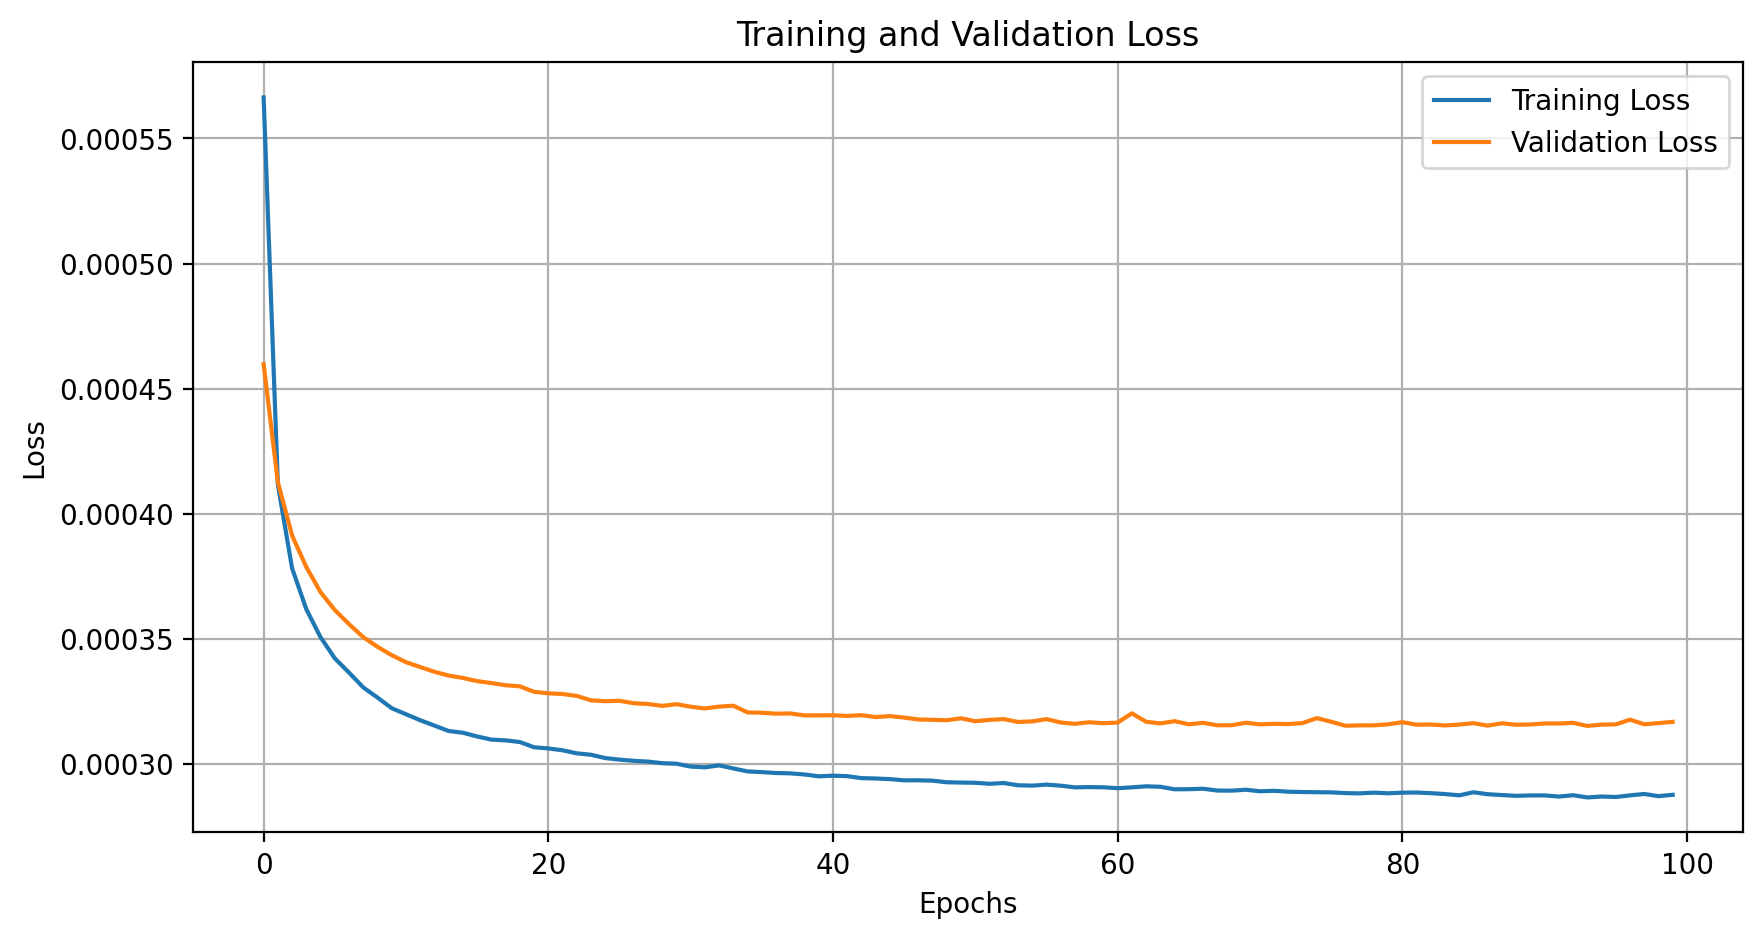

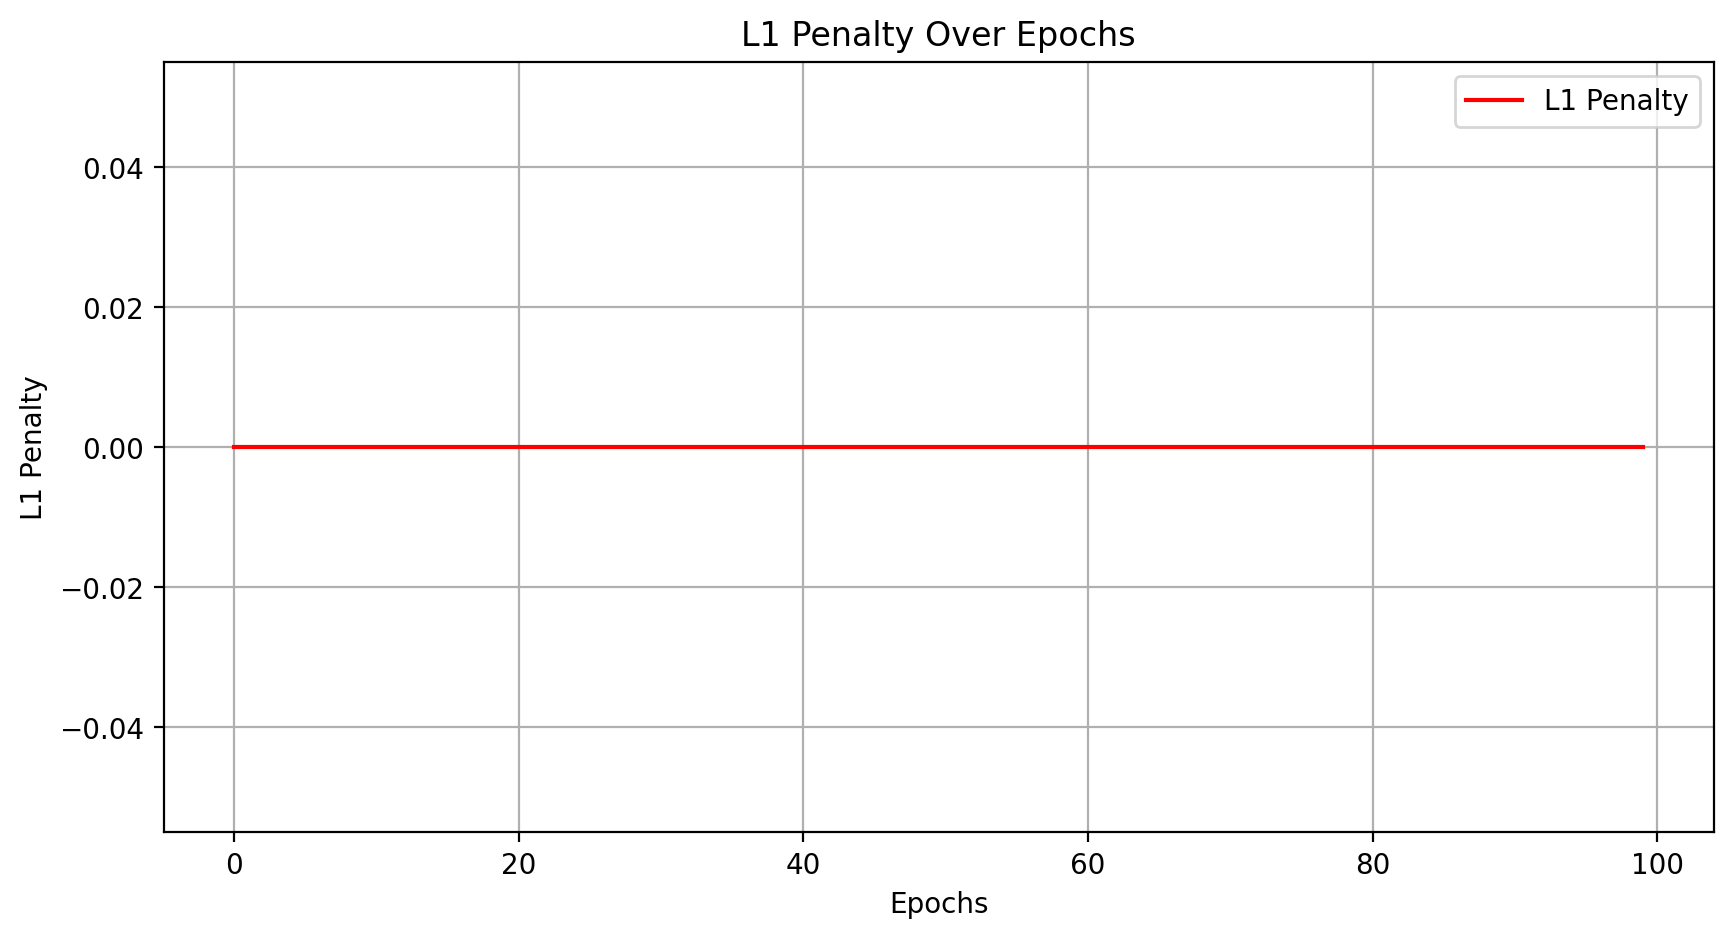

In [153]:
# Example dimensions and settings
num_lags = 4
batch_size = 2000
train_start = 5
normalize = 1000
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate random data for demonstration
X = torch.Tensor(y_session_interp[train_start:,:]/normalize).to(device)
U = torch.Tensor(u_session[train_start:,:]).to(device)
state_dim = X.shape[1] #507
input_dim = U.shape[1] #507

# Create the dataset and dataloader
dataset = TimeseriesDataset(X, U, num_lags)


#train_indices are all the indices minus the test indices
#test_indices were the removed steps from above code

# Split the dataset using the train_data_index and considering the num_lags
train_subset, val_subset = split_dataset(dataset, train_indices[train_start:], num_lags)
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

# Initialize the model
model = LowRankLinearDynamicModel(state_dim, input_dim, rank_dim, num_lags, init_value)

checkpoint_name = 'linear_low_rank_' + str(rank_dim)

print('checkpoint_name:', checkpoint_name)

# Train the model
train_model(model, train_loader, val_loader, epochs = epochs, lr = 0.001, l1_lambda = 0.0, checkpoint_name = checkpoint_name)

In [156]:
print(Ahat[:, num_neurons * (i) :num_neurons * (i+1)])
print(Ahat[:, num_neurons * (i) :num_neurons * (i+1)].shape)

[[ 1.93127679e-03 -2.77546201e-03 -4.32642639e-03 ... -5.25634470e-03
  -2.62680209e-03 -3.19691062e-03]
 [-1.39177364e-02  4.45735144e-01  1.24353631e-03 ...  2.07767847e-02
   9.16414547e-03  7.17885273e-03]
 [ 5.85512300e-03 -4.05672963e-04  1.35926697e-01 ...  4.66313371e-03
   5.25457017e-03  5.58437355e-03]
 ...
 [-1.24934304e-02  1.69369470e-03  3.90672154e-03 ...  1.69363744e-01
  -1.89852128e-03  1.75111632e-02]
 [-1.76852687e-03 -4.27971230e-03 -7.86432496e-03 ... -8.28023239e-03
   1.81680908e-02 -1.08314183e-02]
 [ 1.43765623e-02  2.06694009e-03  1.63278964e-02 ... -2.40759073e-03
   7.86193967e-03  6.20114063e-02]]
(507, 507)


In [158]:
print(rank_dim)
print(state_dim)
print(input_dim)

5
507
507


In [159]:
# Load the best model checkpoint
# Initialize the model
model = LowRankLinearDynamicModel(state_dim, input_dim, rank_dim, num_lags, init_value)
checkpoint_name = 'linear_low_rank_' + str(rank_dim)
checkpoint_path = 'checkpoints/model_best_' + checkpoint_name + '.pt'  # Update the path and filename as needed
model.load_state_dict(torch.load(checkpoint_path))
model.eval()  # Set the model to evaluation mode

init_value = {}
init_value['alpha'] = []
init_value['W_u'] = []
init_value['W_v'] = []
init_value['beta'] = []
init_value['B_u'] = []
init_value['B_v'] = []
init_value['V'] = []

Ahat_list = [] #will concatenate this list, W/A, B, and V

Ahat_list.insert(0, np.expand_dims(to_np(model.V), axis = 1))

init_value['V'].insert(0, to_np(model.V))

#There is num_lags each Bu_k in model.B_u
for Bu_k, Bv_k, betak in zip(model.B_u, model.B_v, model.beta):
    init_value['beta'].insert(0, to_np(betak))
    init_value['B_u'].insert(0, to_np(Bu_k))
    init_value['B_v'].insert(0, to_np(Bv_k))
    Bk = torch.mm(Bu_k, Bv_k.T)#U_B @ V_B.T
    #???????why torch.diag() is it moving 507 across one row to all be on diagonal axis???????
    #betak is([507]), torch.diag(betak) is ([507, 507])
    Ahat_list.insert(0, to_np(singular_value_norm(Bk + torch.diag(betak))))# + D_B 
    
for Wu_k, Wv_k, alphak in zip(model.W_u, model.W_v, model.alpha):
    init_value['alpha'].insert(0, to_np(alphak))
    init_value['W_u'].insert(0, to_np(Wu_k))
    init_value['W_v'].insert(0, to_np(Wv_k))
    Wk = torch.mm(Wu_k, Wv_k.T) #U_A @ V_A.T
    Ahat_list.insert(0, to_np(singular_value_norm(Wk + torch.diag(alphak))))
    
#??????Why are we concatenating the A, B, and V matrices????? 
#Can we work through this together
Ahat_gd = np.concatenate(Ahat_list, axis = 1) #combine them side to side

#Ahat_gd is theta matrix on page 24

np.save('Ahat_D_U_V_low_rank_' + str(rank_dim) + '.npz', init_value)
np.save('Ahat_low_rank_' + str(rank_dim) + '.npy', Ahat_gd)

torch.Size([507, 507])
torch.Size([507])


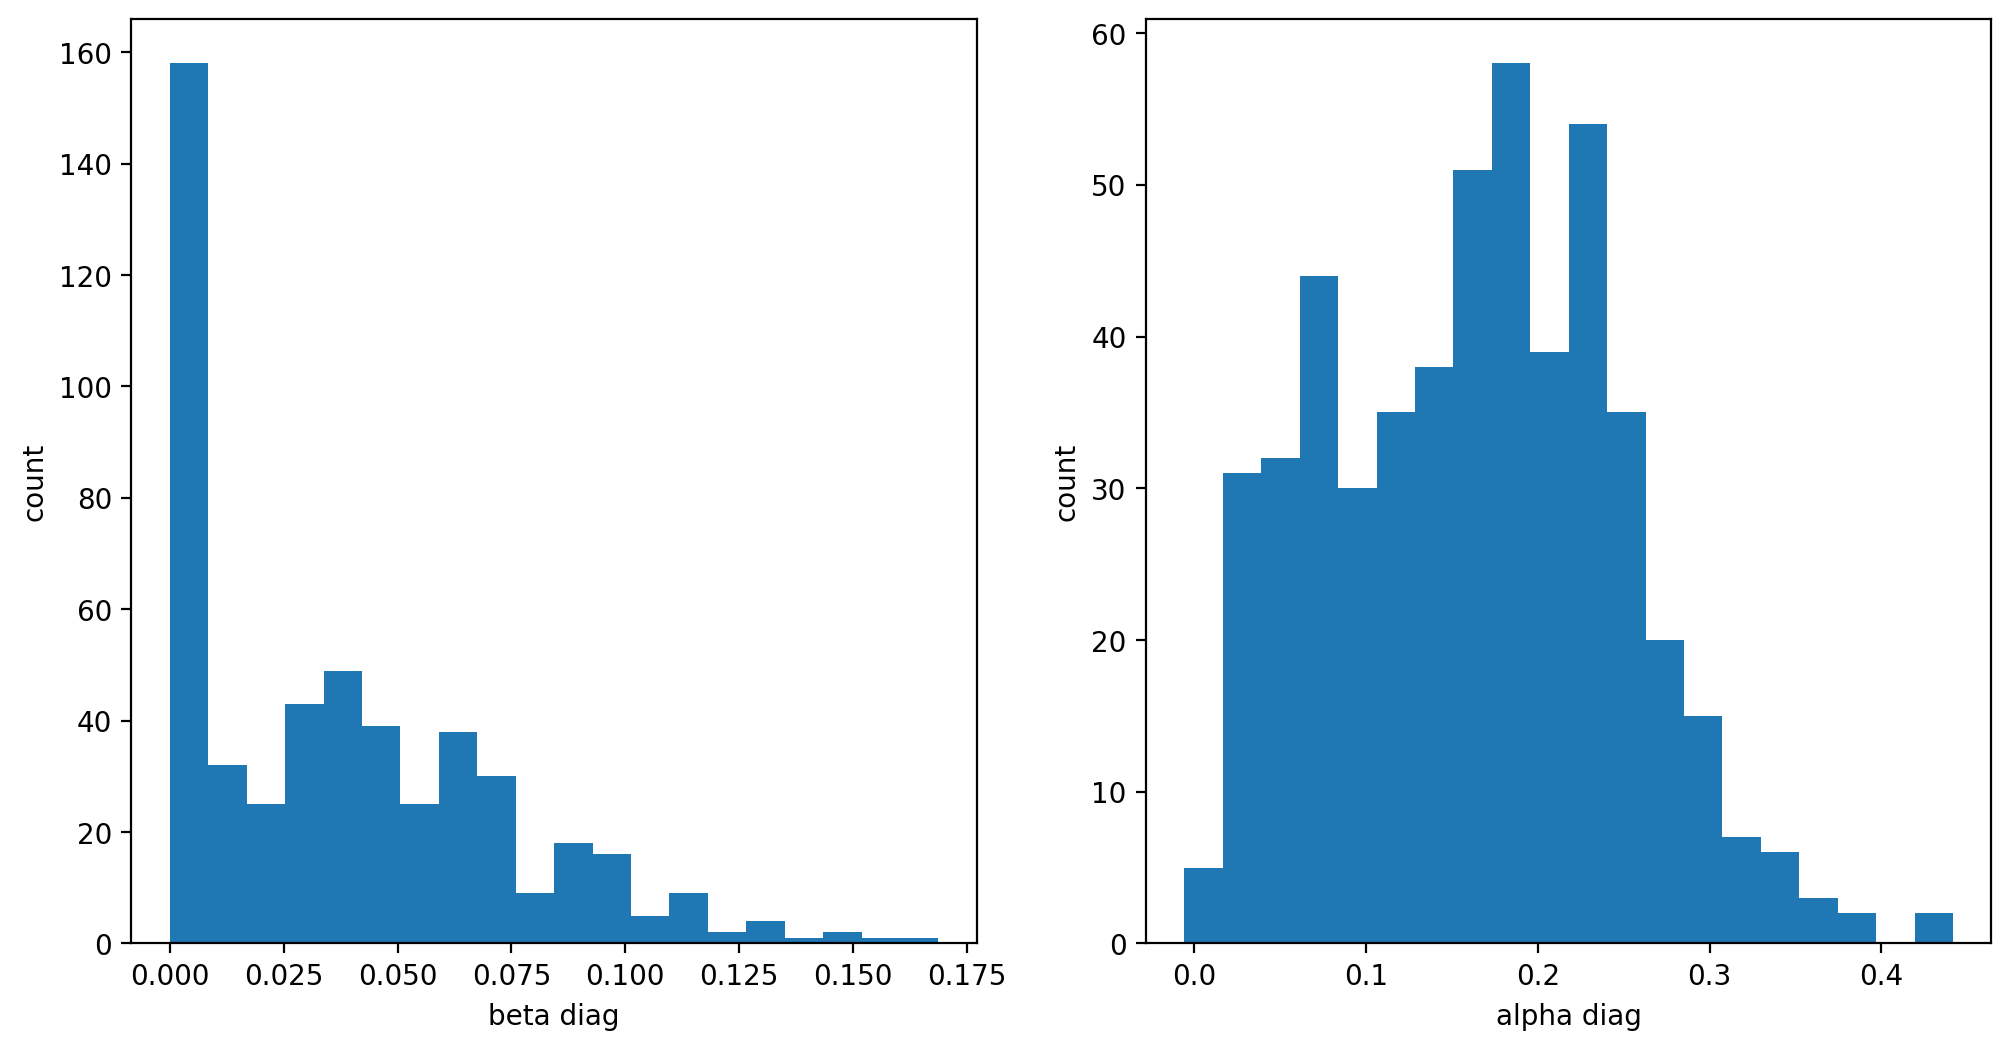

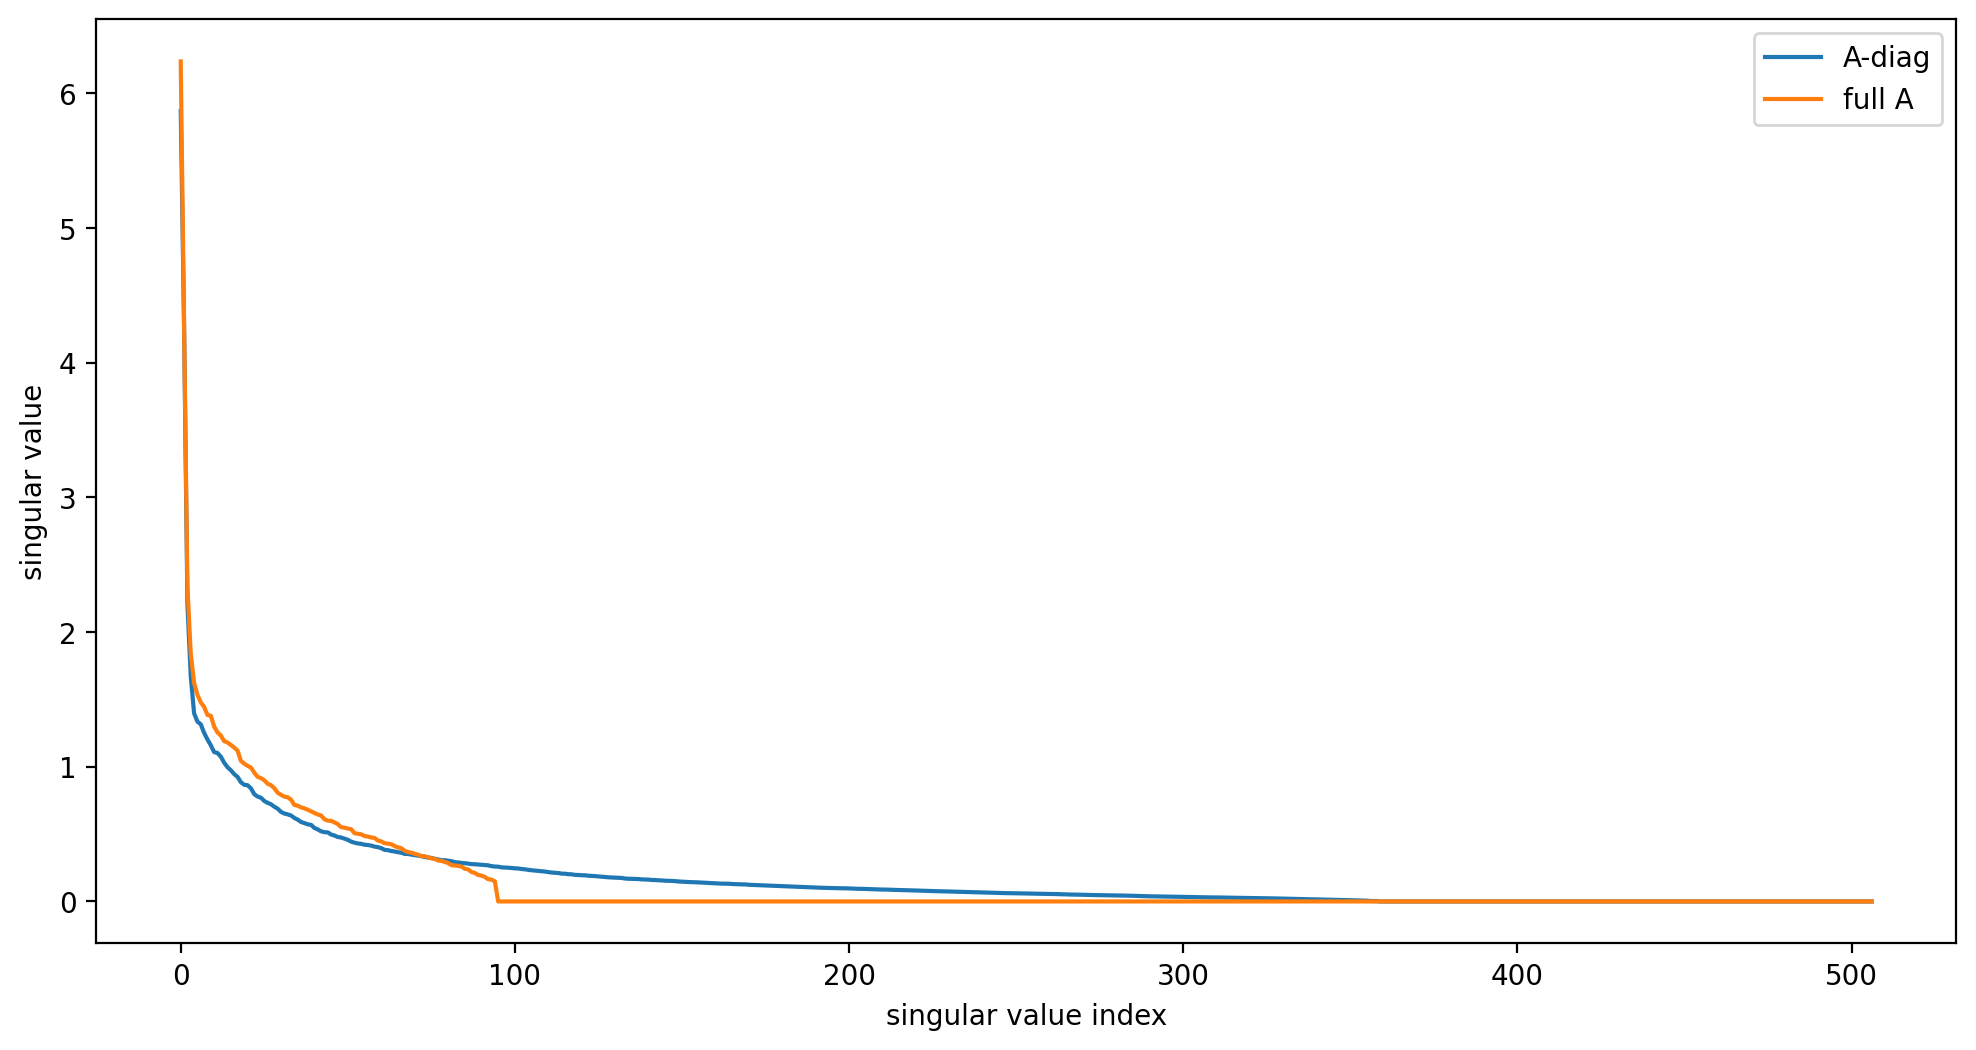

In [173]:
print(torch.diag(betak).shape)
print(betak.shape)

#???????????? Need to understand this plot and the betak, alphak
#these help construct the D_A_s we see in the eq but what exactly are these??????
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(to_np(betak),bins=20)
plt.ylabel('count')
plt.xlabel('beta diag')

plt.subplot(1, 2, 2)
plt.hist(to_np(alphak),bins=20)
plt.ylabel('count')
plt.xlabel('alpha diag')


plt.figure(figsize=(12,6))
plot_rank_svd(A)

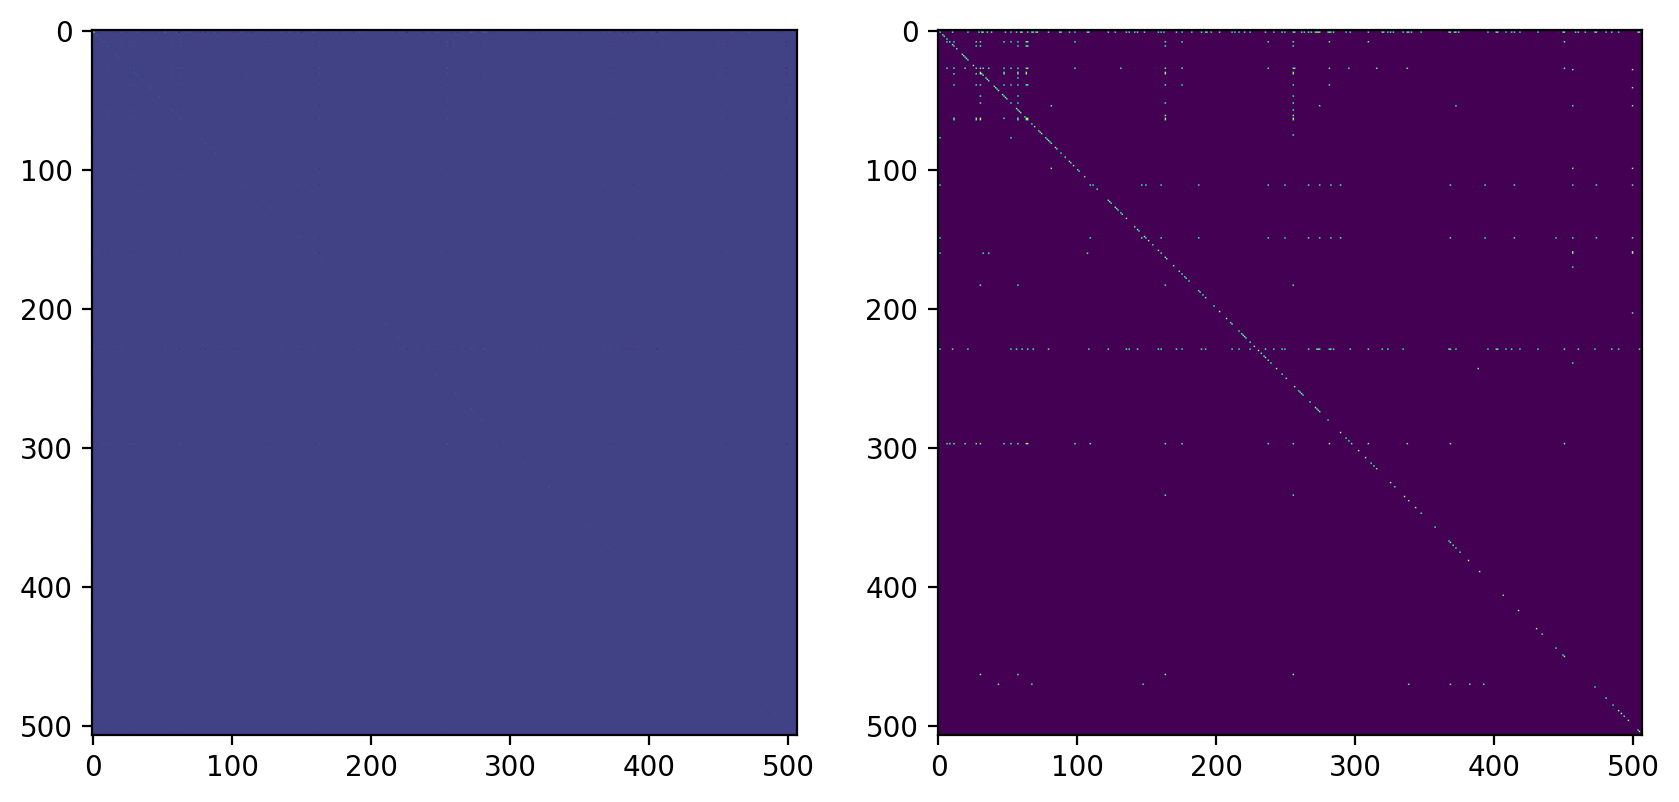

In [174]:
num_neurons = 507
d = num_neurons
A = compute_transfer_matrix(Ahat_gd)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(A)

connection_threshold = 1*np.mean(np.diag(A))
A_threshold = (A > connection_threshold).astype(float)
plt.subplot(1,2,2)
plt.imshow(A > connection_threshold)

In [178]:
print(train_indices.shape[0])

29402


In [176]:
# linear model + gradient descent
x_pred = []
x_true = []
u_true = []
r2 = [] 
idx = -1
ark_order = 4
normalize = 1000
new_segment = True
segment_pred = []
segment_start = -1
for t in range(train_indices.shape[0]):
    if test_indices[t] == 1: #if it is in test set
        if new_segment:
            segment_pred = []
            new_segment = False
            segment_start = t
            x_past = []
            x_pred.append([])
            x_true.append([])
            u_true.append([])
            idx += 1
        if t < segment_start + ark_order:  
        #if t is not within ark_order of segment start, add it to x_past
            x_past.append(y_session_interp[t,:].copy().flatten()/normalize)
        
        #if not new_segment, and if t is outside current segment
        else:
            z = np.array(x_past).flatten()
            
            #concat x_past with u_session t interval data for all neurons
            #?????why concatting the x_past state with the stimulus/input????
            z = np.concatenate((z,u_session[t-ark_order:t,:].copy().flatten(),np.ones(1)))

            #use this the x_past/z concatted with u_session t interval data 
            #to predict x_next with A,hat the linear model weights
            x_next = Ahat_gd @ z
            x_past.pop(0) #pop oldest value
            x_past.append(x_next.copy()) #add the new predicted value
            x_pred[idx].append(x_next.copy())
            x_true[idx].append(y_session_interp[t,:].copy().flatten()/normalize)
            u_true[idx].append(u_session[t,:].copy().flatten())
    else:  #if current t is not part of test set, a new segment should start
        new_segment = True

mse_losses = []
for i in range(len(x_pred)):
    x_pred[i] = np.array(x_pred[i])
    x_true[i] = np.array(x_true[i])
    u_true[i] = np.array(u_true[i])
    mse_losses.append((np.square(x_pred[i] - x_true[i])).mean())
    r2.append(r2_score(x_true[i], x_pred[i]))
print('mse:', sum(mse_losses)/len(mse_losses))
print('r2:', sum(r2)/len(r2))

mse: 0.00052712742788972
r2: -0.17871433712827342


In [209]:
print(len(x_true)) #84
#print(x_true)

print(x_true[0].shape) #(66,507)
# print(x_true[1].shape)
# print(x_true[83].shape)

# print(y_session_interp[t,:].shape) #(507,)
# print(len(y_session_interp[t,:].copy().flatten()/normalize)) #507

print(len(z))



84
(66, 507)
4057


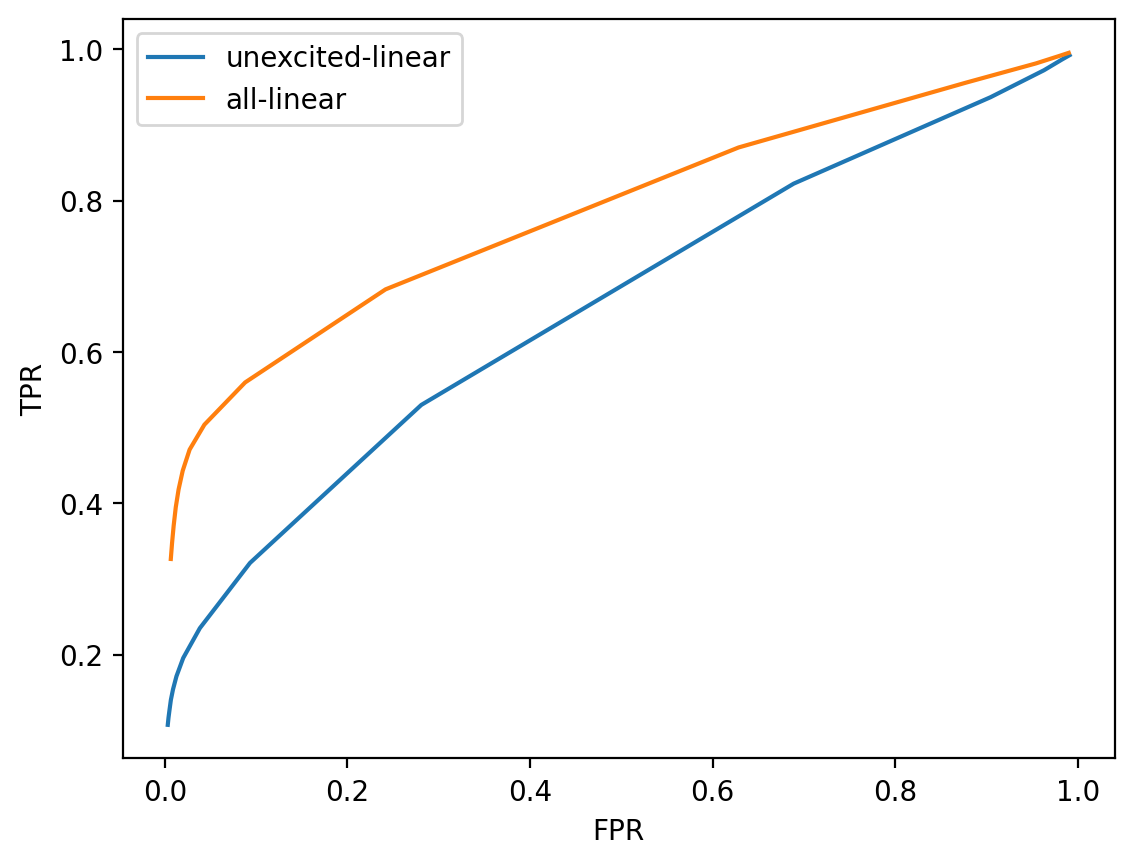

In [179]:
tpr = []
fpr = []
results_name = checkpoint_name
thresholds = np.linspace(-2,5,15)

for thresholds_idx in range(len(thresholds)):
    tp_total = 0
    fp_total = 0
    p_total = 0
    n_total = 0

    for neuron in range(u_session.shape[1]):
        output_pred = []
        output_true = []
        for i in range(len(x_true)):
            output_pred.extend(x_pred[i][:,neuron])
            output_true.extend(x_true[i][:,neuron])
        output_pred = np.array(output_pred)
        output_true = np.array(output_true)
    
        mean_threshold = np.median(output_true)
        lower_tail_idx = (output_true < mean_threshold)
        lower_tail_data = output_true[lower_tail_idx]
        lower_tail_std = np.std(lower_tail_data)
        true_spike_threshold = mean_threshold + 6*lower_tail_std
        detect_spike_threshold = mean_threshold + thresholds[thresholds_idx]*lower_tail_std

        predicted_spikes = (output_pred > detect_spike_threshold)
        true_spikes = (output_true > true_spike_threshold)
        tp_total += np.sum(np.logical_and(predicted_spikes,true_spikes))
        fp_total += np.sum(np.logical_and(predicted_spikes,~true_spikes))
        p_total += np.sum(true_spikes)
        n_total += np.sum(~true_spikes)

    tpr.append(tp_total / p_total)
    fpr.append(fp_total / n_total)


tpr_noninput = []
fpr_noninput = []
thresholds = np.linspace(-2,5,15)

for thresholds_idx in range(len(thresholds)):
    tp_total = 0
    fp_total = 0
    p_total = 0
    n_total = 0

    for neuron in range(u_session.shape[1]):
        output_pred = []
        output_true = []
        for i in range(len(x_true)):
            if np.sum(u_true[i][:,neuron]) == 0:
                output_pred.extend(x_pred[i][:,neuron])
                output_true.extend(x_true[i][:,neuron])
        output_pred = np.array(output_pred)
        output_true = np.array(output_true)
    
        mean_threshold = np.median(output_true)
        lower_tail_idx = (output_true < mean_threshold)
        lower_tail_data = output_true[lower_tail_idx]
        lower_tail_std = np.std(lower_tail_data)
        true_spike_threshold = mean_threshold + 6*lower_tail_std
        detect_spike_threshold = mean_threshold + thresholds[thresholds_idx]*lower_tail_std

        predicted_spikes = (output_pred > detect_spike_threshold)
        true_spikes = (output_true > true_spike_threshold)
        tp_total += np.sum(np.logical_and(predicted_spikes,true_spikes))
        fp_total += np.sum(np.logical_and(predicted_spikes,~true_spikes))
        p_total += np.sum(true_spikes)
        n_total += np.sum(~true_spikes)

    tpr_noninput.append(tp_total / p_total)
    fpr_noninput.append(fp_total / n_total)
    
results = {}
results['fpr'] = fpr
results['tpr'] = tpr
results['fpr_noninput'] = fpr_noninput
results['tpr_noninput'] = tpr_noninput
np.save('results/' + results_name + '.npy', results)

results_load = np.load('results/' + results_name + '.npy', allow_pickle=True).item()

# full data linear model vs non-input neurons only
# ??????? Intuitive that stimulated neurons included would result in
# better spike predictions but just discuss why???
plt.plot(results_load['fpr_noninput'],results_load['tpr_noninput'],label='unexcited-linear')
plt.plot(results_load['fpr'],results_load['tpr'],label='all-linear')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [186]:
print(len(output_pred))
print(x_pred[30][:,neuron].shape)
print(x_pred[40][:,neuron].shape)

1966
(66,)
(66,)


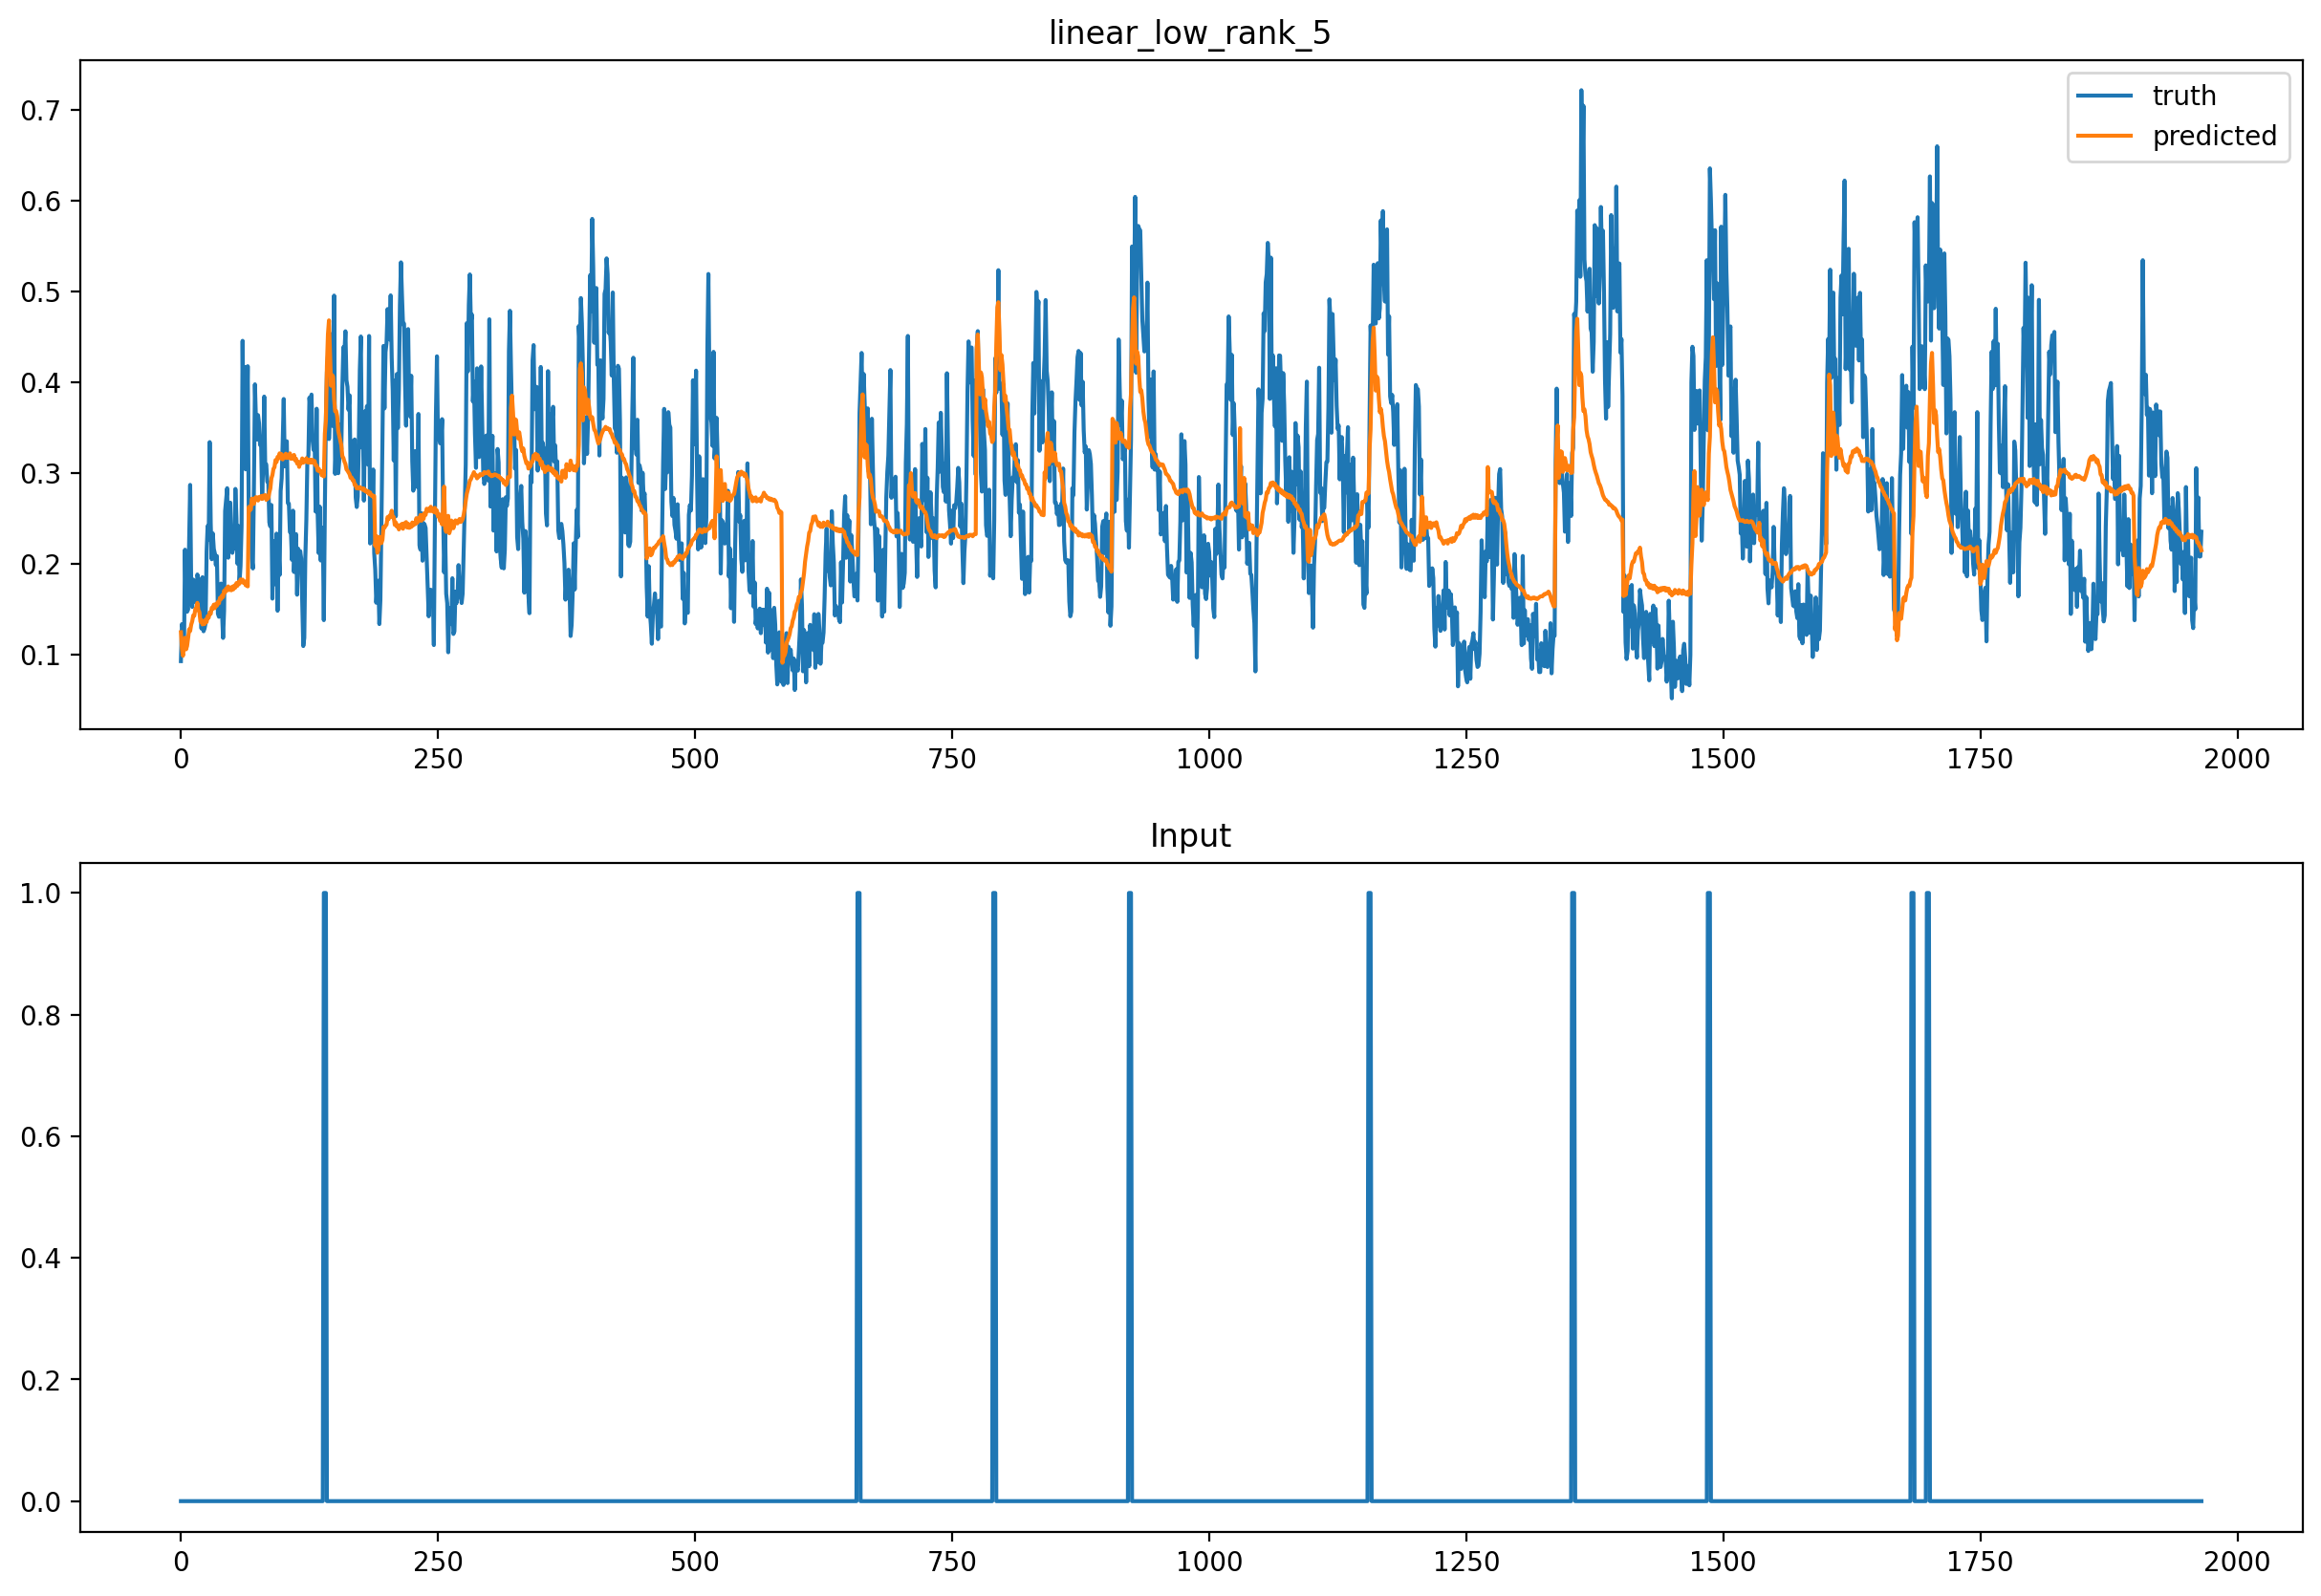

In [180]:
neuron = removed_neurons[9]
length = 50
t_start = 30

win_len = 25

output_pred = []
output_true = []
input_true = []
segment_marker = []

for i in range(t_start, t_start + win_len):
    output_pred.extend(x_pred[i][:,neuron])
    #output_pred.append(np.nan)
    output_true.extend(x_true[i][:,neuron])
    #output_true.append(np.nan)
    input_true.extend(u_true[i][:,neuron])
    #input_true.append(np.nan)
    segment_marker.extend(np.nan*np.zeros(len(x_pred[i][:,neuron])-1))
    segment_marker.extend([0.25,0])
    
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(output_true,label='truth')
plt.plot(output_pred,label='predicted')
#plt.plot(segment_marker)
plt.title(results_name)
plt.legend()

plt.subplot(2,1,2)
plt.plot(input_true,label='input')
plt.title('Input')
plt.savefig('results/' + results_name + '.pdf')



#?????? Why is the low_rank_5 seemingly predicting better than the full_rank?????